# Импорт библиотек

In [1]:
import pandas as pd
from catboost import CatBoostRegressor
import matplotlib.pyplot as plt
import numpy as np 
import seaborn as sns

# Обработка данных

In [2]:
df = pd.read_csv(
    'dano_dataset.csv',
    sep=';',
    engine='python',
    decimal=','
)

Очистка данных, удаление колонок, в которых слишком много NaN для анализа, кроме некоторых, в которых NaN - не ошибка, а заодно и выявление таких колонок и пропусков в строках, которые невозможно заполнить

In [3]:
hotel_specific = ["hotel_country", "hotel_city", 'book_end_dttm']
avia_specific = ["avia_dep_city", "avia_arr_city"]

grouped = df.groupby("order_type_cd")


print("Проверка отелей:")
for col in hotel_specific:
    na_count = grouped.get_group("HOT")[col].isna().sum()
    print(f"{col}: {na_count} пропусков (должно быть 0)")

for col in avia_specific:
    na_count = grouped.get_group("HOT")[col].isna().sum()
    print(f"{col}: {na_count} пропусков (должно быть {len(grouped.get_group('HOT'))})")

print("\nПроверка авиабилетов:")
for col in avia_specific:
    na_count = grouped.get_group("AIR")[col].isna().sum()
    print(f"{col}: {na_count} пропусков (должно быть 0)")

for col in hotel_specific:
    na_count = grouped.get_group("AIR")[col].isna().sum()
    print(f"{col}: {na_count} пропусков (должно быть {len(grouped.get_group('AIR'))})")

Проверка отелей:
hotel_country: 9300 пропусков (должно быть 0)
hotel_city: 9300 пропусков (должно быть 0)
book_end_dttm: 0 пропусков (должно быть 0)
avia_dep_city: 171548 пропусков (должно быть 171548)
avia_arr_city: 171548 пропусков (должно быть 171548)

Проверка авиабилетов:
avia_dep_city: 62 пропусков (должно быть 0)
avia_arr_city: 62 пропусков (должно быть 0)
hotel_country: 615337 пропусков (должно быть 615337)
hotel_city: 615337 пропусков (должно быть 615337)
book_end_dttm: 615337 пропусков (должно быть 615337)


## Обработка настоящих пропусков в переменных, которые зависят от подгрупп

In [4]:
df_cleaned = df.dropna(subset=["order_type_cd"]).copy()

mask_hot_bad = (
    (df["order_type_cd"] == "HOT") & 
    (df[["hotel_country", "hotel_city"]].isna().any(axis=1))
)

mask_air_bad = (
    (df["order_type_cd"] == "AIR") & 
    (df[["avia_dep_city", "avia_arr_city"]].isna().any(axis=1))
)

total_mask = mask_hot_bad | mask_air_bad

df_cleaned = df_cleaned[~total_mask]

print(f"Удалено строк: {len(df) - len(df_cleaned)}, {(len(df) - len(df_cleaned)) / len(df) * 100:.2f}% ")
print(f"Осталось строк: {len(df_cleaned)}, {len(df_cleaned) / len(df) * 100:.2f}%")


hotel_group = df_cleaned[df_cleaned["order_type_cd"] == "HOT"]
avia_group = df_cleaned[df_cleaned["order_type_cd"] == "AIR"]

print("\nПроверка отелей:")
print("hotel_country пропуски:", hotel_group["hotel_country"].isna().sum())  
print("hotel_city пропуски:", hotel_group["hotel_city"].isna().sum())        

print("\nПроверка авиабилетов:")
print("avia_dep_city пропуски:", avia_group["avia_dep_city"].isna().sum())  
print("avia_arr_city пропуски:", avia_group["avia_arr_city"].isna().sum())  

/tmp/ipykernel_389187/2549780844.py:15: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_cleaned = df_cleaned[~total_mask]


Удалено строк: 58415, 6.99% 
Осталось строк: 777523, 93.01%

Проверка отелей:
hotel_country пропуски: 0
hotel_city пропуски: 0

Проверка авиабилетов:
avia_dep_city пропуски: 0
avia_arr_city пропуски: 0


Заполнение этих пропусков отдельным классом

In [5]:
# Здесь nan это не ошибка, а наоборот, заполняем 0, а наличие ошибки единицей
df_cleaned['bounce_cd'] = df_cleaned['bounce_cd'].fillna(0).apply(lambda x: 0 if x == 0 else 1)

# А здесь как выяснилось все зависит от подгруппы и настоящие пропуски я удалил

df_cleaned['hotel_city'] = df_cleaned['hotel_city'].fillna('NA') 
df_cleaned['hotel_country'] = df_cleaned['hotel_country'].fillna('NA') 
df_cleaned['avia_dep_city'] = df_cleaned['avia_dep_city'].fillna("NA")
df_cleaned['avia_arr_city'] = df_cleaned['avia_arr_city'].fillna("NA")
df_cleaned['book_end_dttm'] = df_cleaned['book_end_dttm'].fillna("NA")

Удаляем колонки, в которых >70% пропусков и они не связаны с подгруппами

In [6]:
df_cleaned = df_cleaned.dropna(thresh=int(0.3 * len(df)), axis=1)
df_cleaned.shape, (set(df.columns) - set(df_cleaned.columns) & set(df.columns))

((777523, 48),
 {'bad_email_address_flg',
  'call_contact_1m_flg',
  'call_contact_3m_flg',
  'call_contact_6m_flg',
  'cancel_dttm',
  'free_cancel_booking_dttm',
  'good_email_address_flg',
  'last_email_send_dt'})

Осталось 48 столбцов, удаленные столбцы: 
{'bad_email_address_flg',
  'book_end_dttm',
  'call_contact_1m_flg',
  'call_contact_3m_flg',
  'call_contact_6m_flg',
  'cancel_dttm',
  'free_cancel_booking_dttm',
  'good_email_address_flg',
  'hotel_city',
  'hotel_country',
  'last_email_send_dt'}

Выявление реальных пропусков по программе лояльности

In [7]:
nan_count = df_cleaned['loyalty_program_type_nm'].isna().sum()
print(f"Пропуски в loyalty_program_type_nm: {nan_count}")

nan_mask = df_cleaned['loyalty_program_type_nm'].isna()

conflict_rows = df_cleaned[nan_mask]['loyalty_accrual_rub_amt'] > 0

conflict_count = conflict_rows.sum()
print(f"Количество строк с пропуском в программе и начислениями > 0: {conflict_count}")

Пропуски в loyalty_program_type_nm: 30160
Количество строк с пропуском в программе и начислениями > 0: 2271


объединение в подгруппы программы лояльности и удаление лишних

In [8]:
conflict_mask = df_cleaned['loyalty_program_type_nm'].isna() & (df_cleaned['loyalty_accrual_rub_amt'] > 0)
df_cleaned = df_cleaned[~conflict_mask]  

df_cleaned['loyalty_program_type_nm'] = df_cleaned['loyalty_program_type_nm'].fillna('Нет')

loyalty_mapping = {
    'Tinkoff Black': 'Тинькоф',
    'Tinkoff Black Premium': 'Тинькоф',
    'Tinkoff Platinum': 'Тинькоф',
    'Tinkoff Drive': 'Тинькоф',
    'Tinkoff Black Private': 'Тинькоф',
    'Tinkoff Mobile': 'Тинькоф',
    'Tinkoff Junior': 'Тинькоф',
    'All Airlines': 'Airlines',
    'All Airlines Premium': 'Airlines',
    'All Airlines Premium Кредитный': 'Airlines',
    'All Airlines Private Кредитный': 'Airlines',
    'S7': 'Другое',
    'S7Debit': 'Другое',
    'S7 Tinkoff Premium': 'Другое',
    'WargamingTanksDebit': 'Другое',
    'All Games Debit': 'Другое',
    'Lukoil': 'Другое',
    'Lamoda': 'Другое',
    'AliExpress': 'Другое'
}

df_cleaned['loyalty_group'] = df_cleaned['loyalty_program_type_nm'].map(loyalty_mapping).fillna('Нет')

df_cleaned = df_cleaned[df_cleaned['loyalty_group'] != 'Другое']

Осталось:

In [9]:
len(df_cleaned) / len(df) * 100

92.36510363208754

Удаляем теперь не нужную колонку

In [10]:
df_cleaned.drop('loyalty_program_type_nm', axis=1, inplace=True)

Заполняем пропуски по количеству детей модой, пропуски по региону проживания городом, при отсутствии удаляем, создаем отдельные классы для не указанной степени образования и семейного статуса.Заполняем нулями отсутствие бонусов.
Заполняем доход средним по подгруппе образования (ну или нет)
Также удаляем незначительные пропуски и пропуски, которые невозможно восстановить

In [11]:
print(df_cleaned.shape)

df_cleaned['marital_status_cd'] = df_cleaned['marital_status_cd'].fillna('UNK')
df_cleaned['education_level_cd'] = df_cleaned['education_level_cd'].fillna('UNSPECIFIED')

city_to_region = df_cleaned.dropna(subset=['lvn_city_nm', 'lvn_state_nm']).groupby('lvn_city_nm')['lvn_state_nm'].first().to_dict()

df_cleaned['lvn_state_nm'] = df_cleaned.apply(
    lambda row: city_to_region.get(row['lvn_city_nm'], row['lvn_state_nm']),
    axis=1
)

df_cleaned = df_cleaned.dropna(subset=['lvn_city_nm', 'lvn_state_nm'], how='all')
df_cleaned.drop('lvn_city_nm', axis=1, inplace=True)

df_cleaned['promo_code_discount_amt'] = df_cleaned['promo_code_discount_amt'].fillna(0)
df_cleaned['loyalty_accrual_rub_amt'] = df_cleaned['loyalty_accrual_rub_amt'].fillna(0)

valid_bundles = ['Pro', 'Premium', "NA"]
df_cleaned['bundle_nm'] = df_cleaned['bundle_nm'].fillna('NA')
df_cleaned = df_cleaned[df_cleaned['bundle_nm'].isin(valid_bundles)]

# df_cleaned['children_cnt'] = df_cleaned['children_cnt'].fillna(0)

df_cleaned = df_cleaned.dropna(subset=['birth_place', 'gender_cd'])

print("Оставшиеся пропуски:")
print(df_cleaned.isna().sum())

len(df_cleaned)

(772115, 48)
Оставшиеся пропуски:
order_online_payment_flg            0
account_rk                          0
client_rk                           0
order_rk                            0
bundle_nm                           0
order_type_cd                       0
order_status_cd                     0
party_first_order_dt                0
party_first_order_type_dt          54
created_dttm                        0
book_start_dttm                     0
local_book_start_dttm               0
book_end_dttm                       0
hotel_country                       0
hotel_city                          0
avia_dep_city                       0
avia_arr_city                       0
promo_code_discount_amt             0
loyalty_accrual_rub_amt             0
nominal_price_eur_amt               0
nominal_price_rub_amt               0
order_item_cnt                 147243
month_beginning_balance_rub      9749
monthly_income_amt             106069
suppress_email_flg                  0
suppress_call_fl

707929

In [12]:
a = ['children_cnt', 'monthly_income_amt', 'month_beginning_balance_rub', 
     'party_first_order_type_dt', 'last_sms_success_flg', 'age_type_cd',
       'lvn_state_nm', 'first_used_product_cd', 'mobile_phone_operator_nm', 
       'last_sms_dt']
# df_cleaned.drop(a, axis=1, inplace=True)
df_cleaned = df_cleaned.dropna(subset=a)
len(df_cleaned), len(df_cleaned) / len(df) * 100

(552465, 66.08923149802976)

In [13]:
df_cleaned.shape

(552465, 47)

In [14]:
df_cleaned['order_item_cnt'] = df_cleaned['order_item_cnt'].fillna(1) # Модой заполняем

# income_by_education = df_cleaned.groupby("education_level_cd")["monthly_income_amt"].mean().to_dict()

# df_cleaned["monthly_income_amt"] = df_cleaned.apply(
#     lambda row: income_by_education[row["education_level_cd"]] 
#                 if pd.isna(row["monthly_income_amt"]) 
#                 else row["monthly_income_amt"],
#     axis=1
# )

# df_cleaned['month_beginning_balance_rub'] = df_cleaned['month_beginning_balance_rub'].fillna(df_cleaned['month_beginning_balance_rub'].mean())

df_cleaned.drop('parent_meeting_region_nm', axis = 1, inplace=True)

df_cleaned.isna().sum()

order_online_payment_flg       0
account_rk                     0
client_rk                      0
order_rk                       0
bundle_nm                      0
order_type_cd                  0
order_status_cd                0
party_first_order_dt           0
party_first_order_type_dt      0
created_dttm                   0
book_start_dttm                0
local_book_start_dttm          0
book_end_dttm                  0
hotel_country                  0
hotel_city                     0
avia_dep_city                  0
avia_arr_city                  0
promo_code_discount_amt        0
loyalty_accrual_rub_amt        0
nominal_price_eur_amt          0
nominal_price_rub_amt          0
order_item_cnt                 0
month_beginning_balance_rub    0
monthly_income_amt             0
suppress_email_flg             0
suppress_call_flg              0
bounce_cd                      0
last_sms_success_flg           0
email_valid_flg                0
children_cnt                   0
age       

Удаляем по возрасту

In [15]:
df_cleaned = df_cleaned[df_cleaned['loyalty_accrual_rub_amt'] < 175000]

In [16]:
df_cleaned = df_cleaned[df_cleaned['age'].isin(range(20, 61))]
df_cleaned.shape

(543988, 46)

In [17]:
print(len(df_cleaned) / len((df)) * 100)

65.07516107653916


## Итого:

Теперь все пропущенные данные обработаны, лишние колонки и строчки удалены, осталось 543 989 строчек или 65% от данных.

In [18]:
import gc
del df

gc.collect() 

31

# Графики

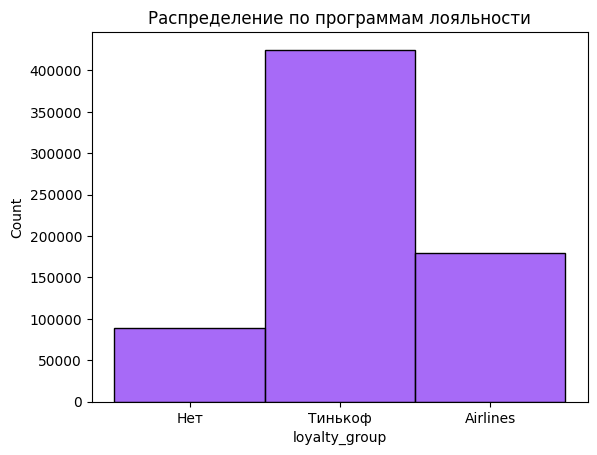

In [26]:
sns.histplot(df_cleaned['loyalty_group'], color='#8A38F5')
plt.title('Распределение по программам лояльности')
plt.show()

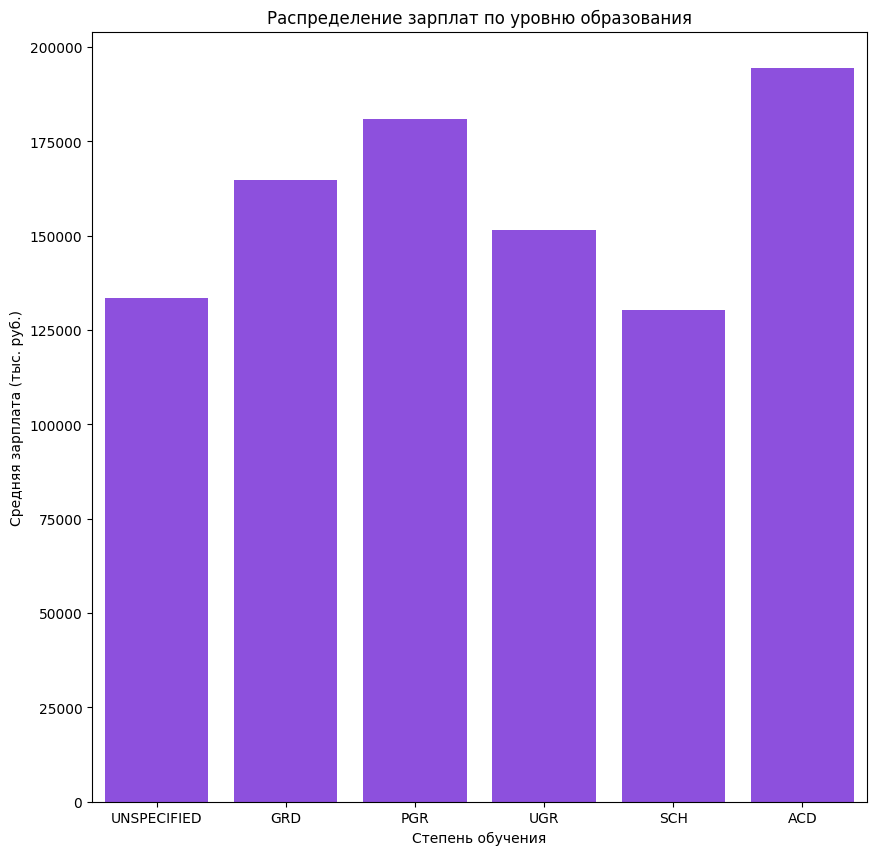

In [15]:
ed_grouped = df_cleaned.groupby(by=df_cleaned['education_level_cd'])
groups = df_cleaned['education_level_cd'].unique()

heh = {}

for i in groups:
    heh[i] = ed_grouped.get_group(i)['monthly_income_amt'].mean()

plt.figure(figsize=(10, 10))
sns.barplot(heh, color='#8A38F5')
plt.title("Распределение зарплат по уровню образования")
plt.xlabel('Степень обучения')
plt.ylabel('Средняя зарплата (тыс. руб.)')
plt.show()

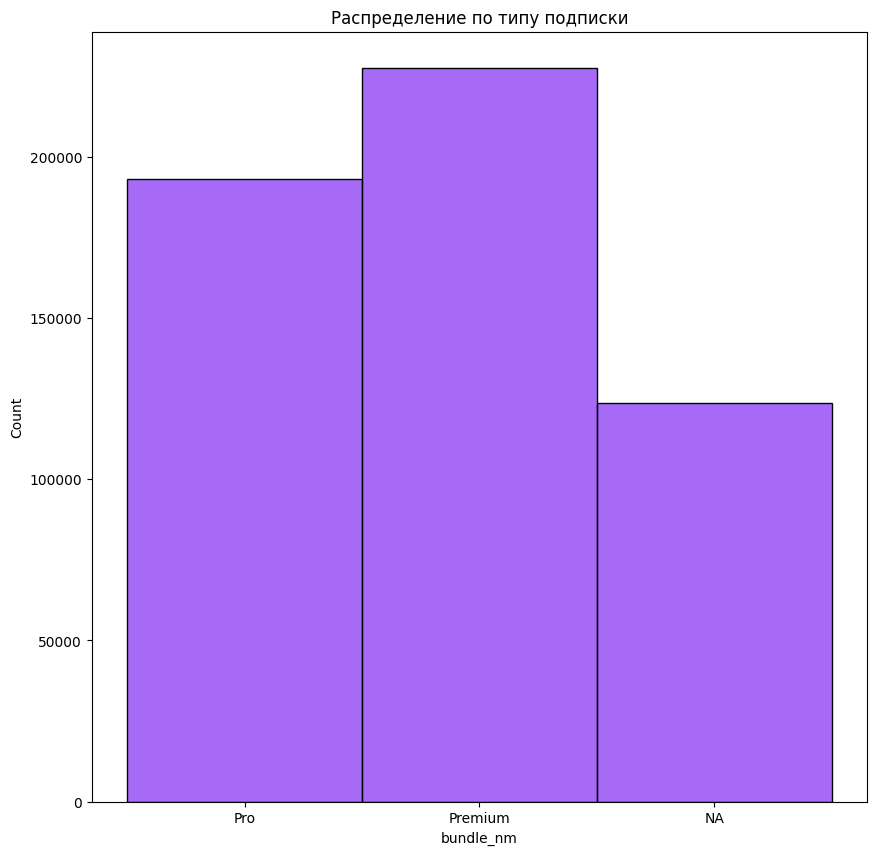

In [16]:
plt.figure(figsize=(10, 10))
sns.histplot(df_cleaned['bundle_nm'], color='#8A38F5')
plt.title('Распределение по типу подписки')
plt.show()

Распределение зарплат в целом это считать выбросами тяжело, отрицательных значений нет, значит оставляем

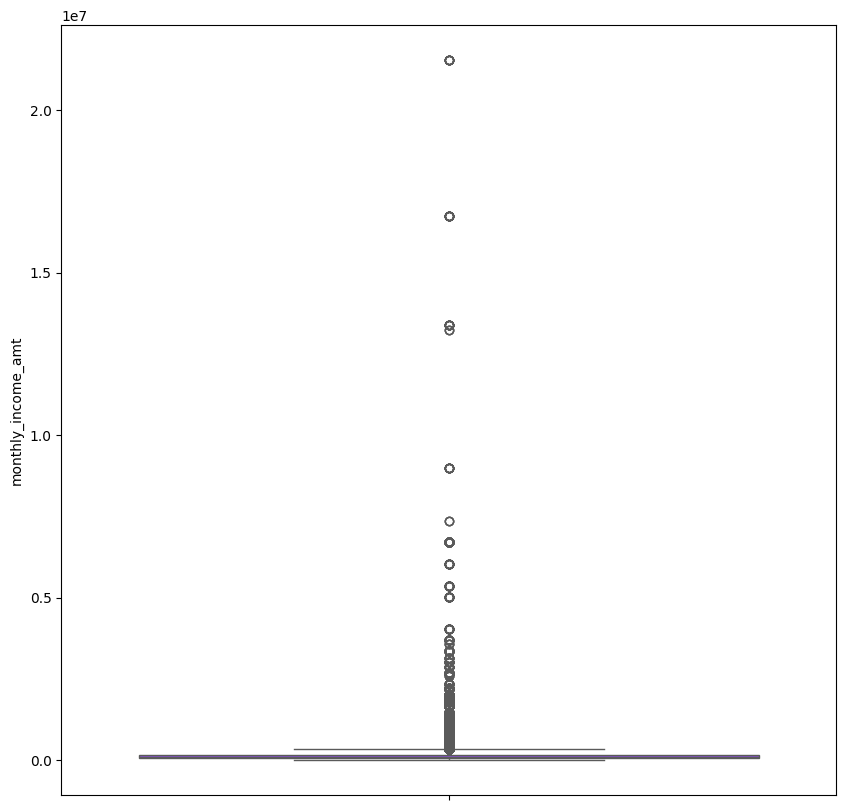

In [21]:
plt.figure(figsize=(10, 10))
sns.boxplot(df_cleaned['monthly_income_amt'], color='#8A38F5')
plt.show()

По датам нет в целом никаких проблем

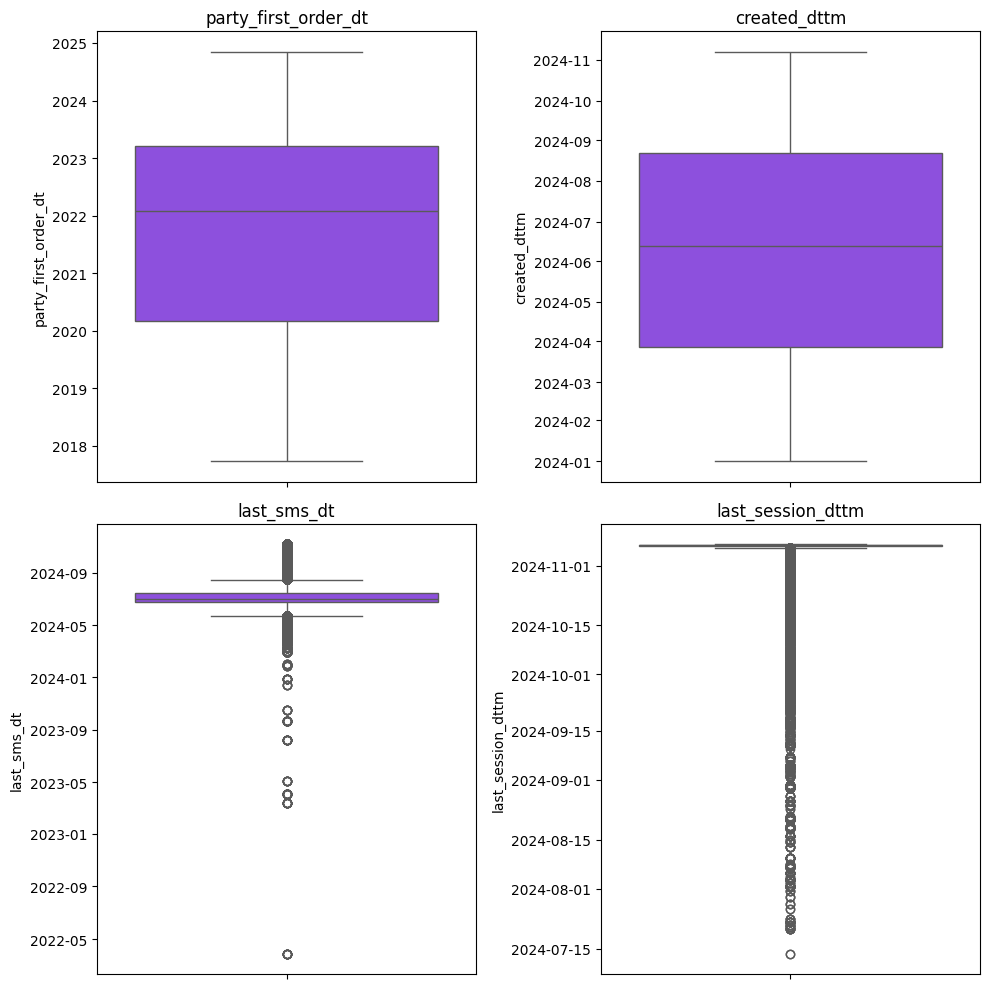

In [22]:
n = ['party_first_order_dt', 'created_dttm',
    'last_sms_dt', 'last_session_dttm']

num_plots = len(n)
num_cols = 2 
num_rows = (num_plots + 1) // num_cols  

plt.figure(figsize=(10, 5 * num_rows))  

for i in range(num_plots):
    plt.subplot(num_rows, num_cols, i + 1)  
    sns.boxplot(df_cleaned[n[i]], color='#8A38F5')
    plt.title(n[i])  

plt.tight_layout()  
plt.show()

До очистки выбросов:

<Axes: xlabel='age', ylabel='Count'>

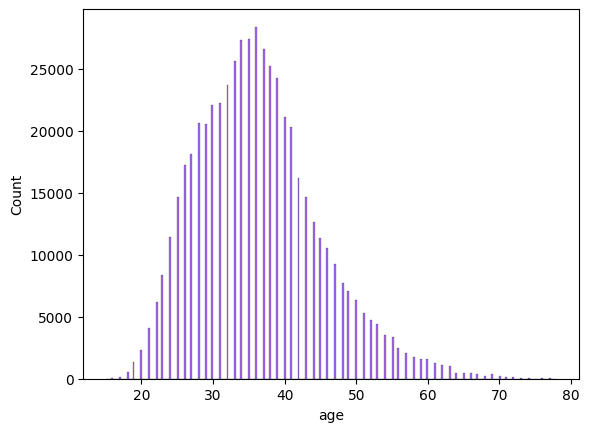

In [39]:
sns.histplot(df_cleaned['age'], color='#8A38F5')

После очистки выбросов:

<Axes: xlabel='age', ylabel='Count'>

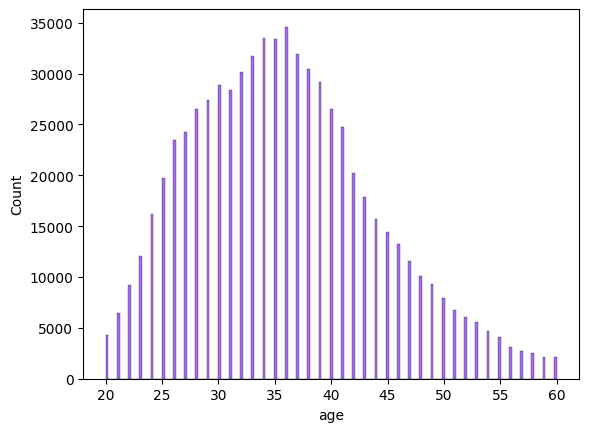

In [29]:
sns.histplot(df_cleaned['age'], color='#8A38F5')

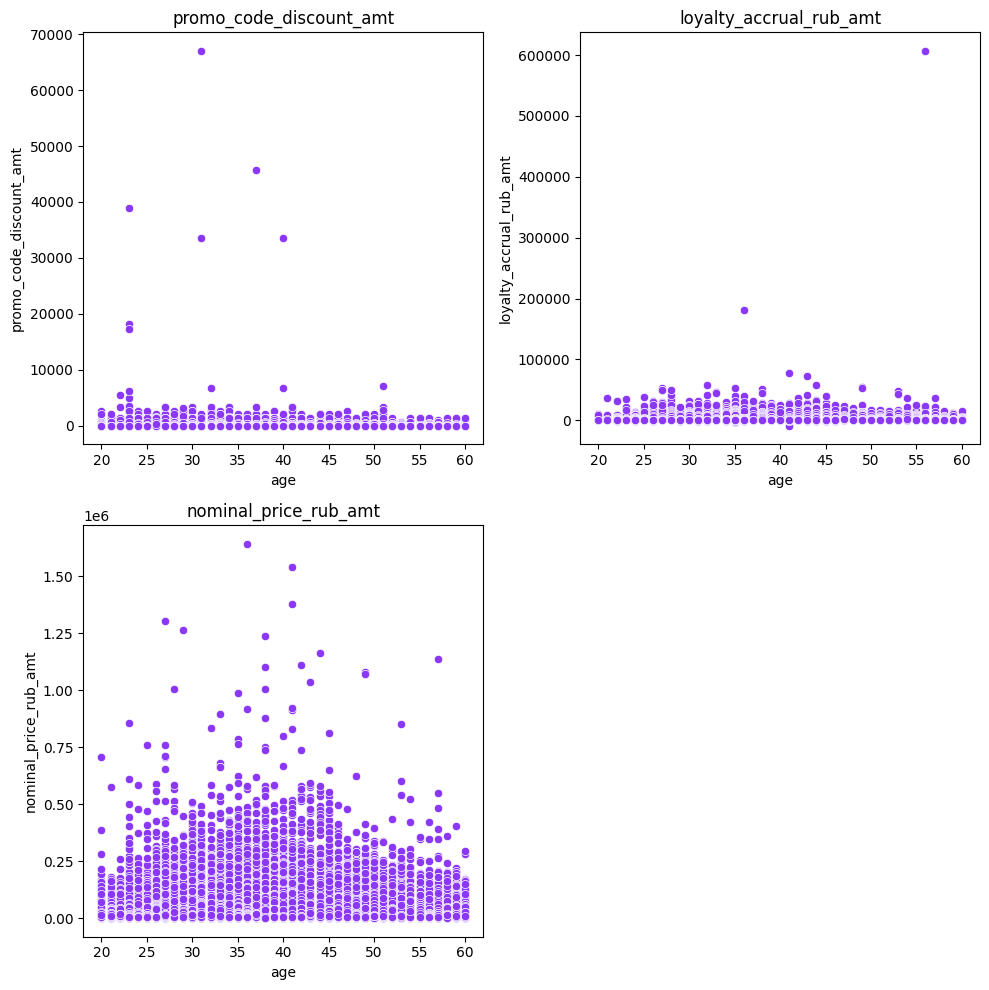

In [27]:
n_df = list(df_cleaned.select_dtypes(include=np.number).columns)
n_df.remove('age')
n_df.remove('order_online_payment_flg')
n_df.remove('suppress_email_flg')
n_df.remove('suppress_call_flg')
n_df.remove('bounce_cd')
n_df.remove('email_valid_flg')
n_df.remove('time_zone_delta_hours')
n_df.remove('order_item_cnt')
n_df.remove('nominal_price_eur_amt')
age_col = df_cleaned['age']

num_plots = len(n_df)
num_cols = 2
num_rows = (num_plots + 1) // num_cols  

plt.figure(figsize=(10, 5 * num_rows))  

for i in range(num_plots):
    plt.subplot(num_rows, num_cols, i + 1)  
    sns.scatterplot(x=age_col, y=df_cleaned[n_df[i]], color='#8A38F5')
    plt.title(n_df[i])  

plt.tight_layout()  
plt.show()

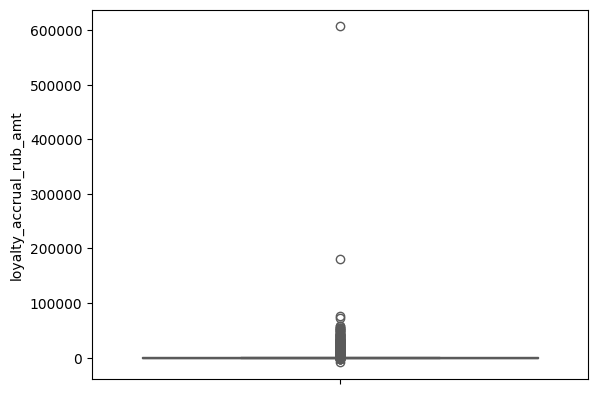

In [32]:
sns.boxplot(df_cleaned['loyalty_accrual_rub_amt'], color='#8A38F5')
plt.show()

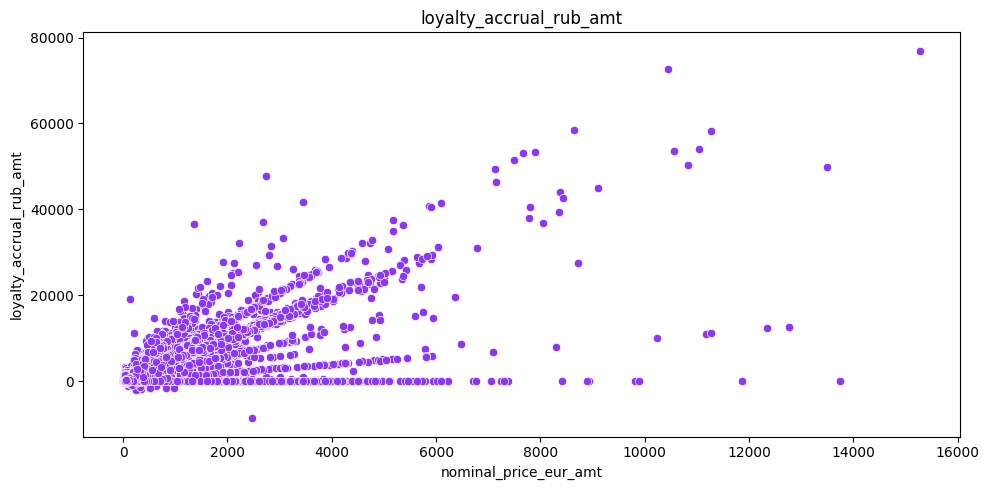

In [29]:
loyalities = ['loyalty_accrual_rub_amt']

num_plots = len(loyalities)
num_cols = 1
num_rows = (num_plots + num_cols - 1) // num_cols  

plt.figure(figsize=(10, 5 * num_rows))

for i in range(num_plots):
    plt.subplot(num_rows, num_cols, i + 1)  
    sns.scatterplot(x=df_cleaned['nominal_price_eur_amt'], y=df_cleaned[loyalities[i]], color='#8A38F5')
    plt.title(loyalities[i]) 
  
plt.tight_layout()
plt.show()

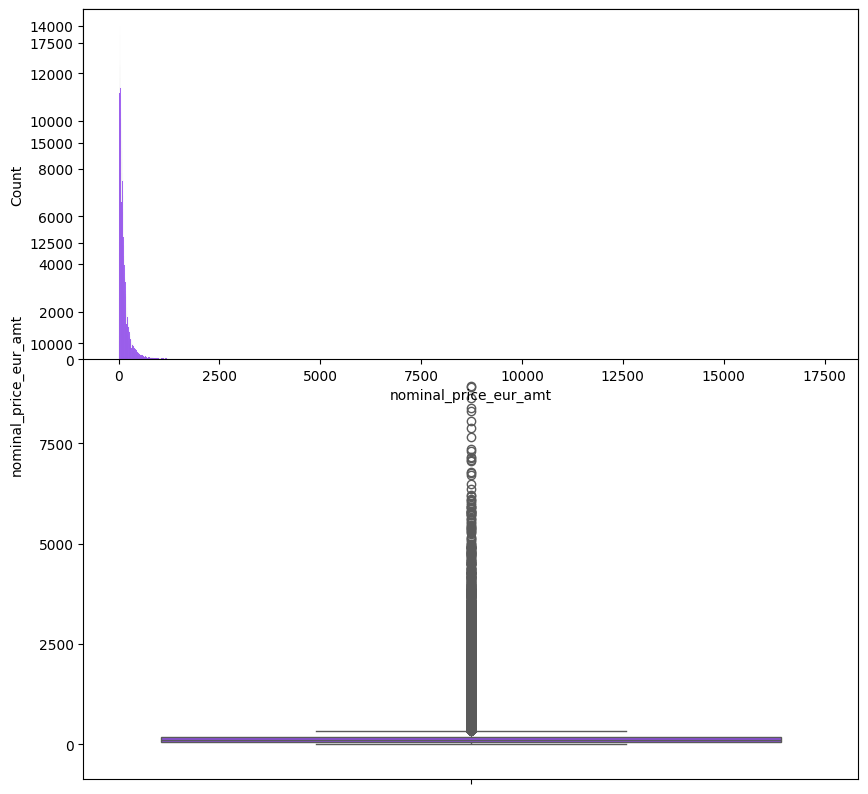

In [ ]:
plt.figure(figsize=(10, 10))
plt.subplot(1, 1, 1)
sns.boxplot(df_cleaned['nominal_price_rub_amt'], color="#8A38F5")

plt.subplot(2, 1, 1)
sns.histplot(df_cleaned['nominal_price_rub_amt'], color='#8A38F5')

plt.show()

## Построение матрицы корреляций

In [20]:
n_df = df_cleaned.select_dtypes(include=np.number)
n_df.drop(['order_online_payment_flg', 'suppress_email_flg', 'suppress_call_flg', 'bounce_cd', 'last_sms_success_flg', 'email_valid_flg'], axis=1, inplace=True)

In [ ]:
corr = n_df.corr()

<function matplotlib.pyplot.show(close=None, block=None)>

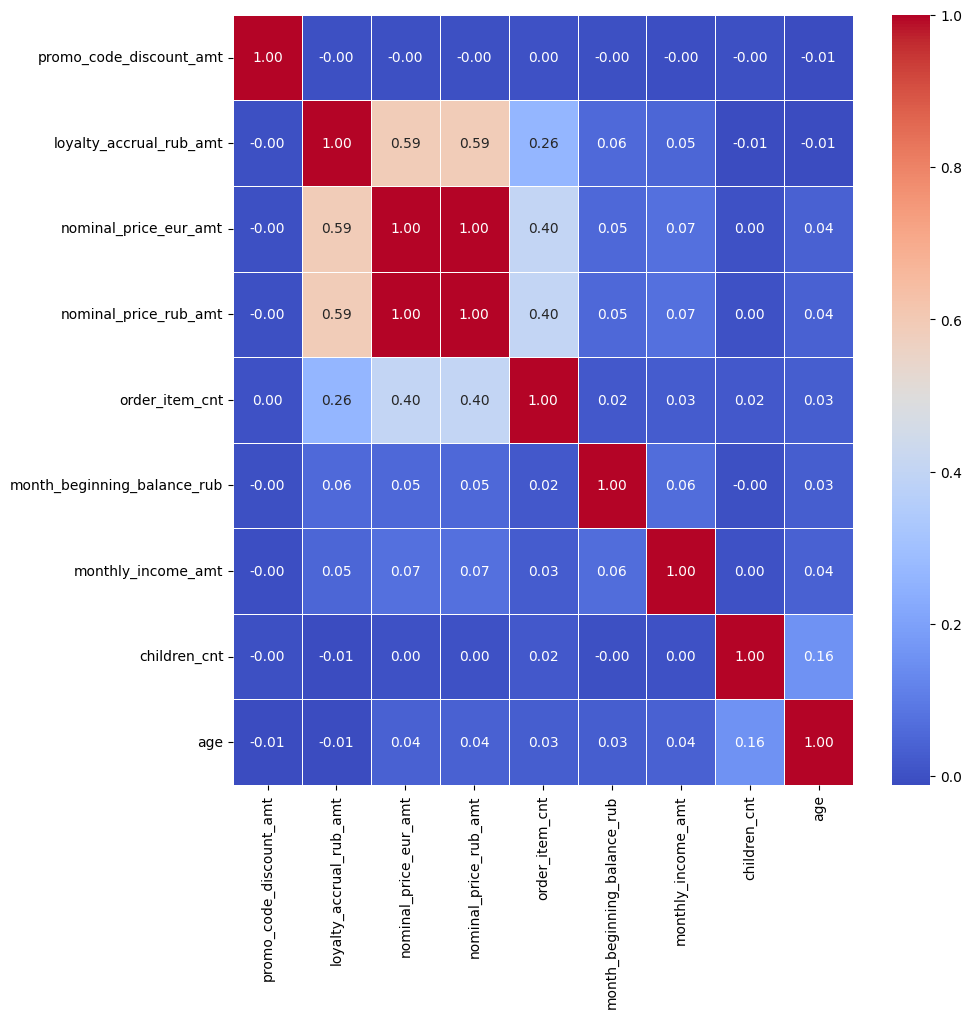

In [22]:
plt.figure(figsize=(10, 10))
sns.heatmap(corr, annot=True, fmt=".2f", linewidths=0.5, cmap='coolwarm')
plt.show

## Pairplot

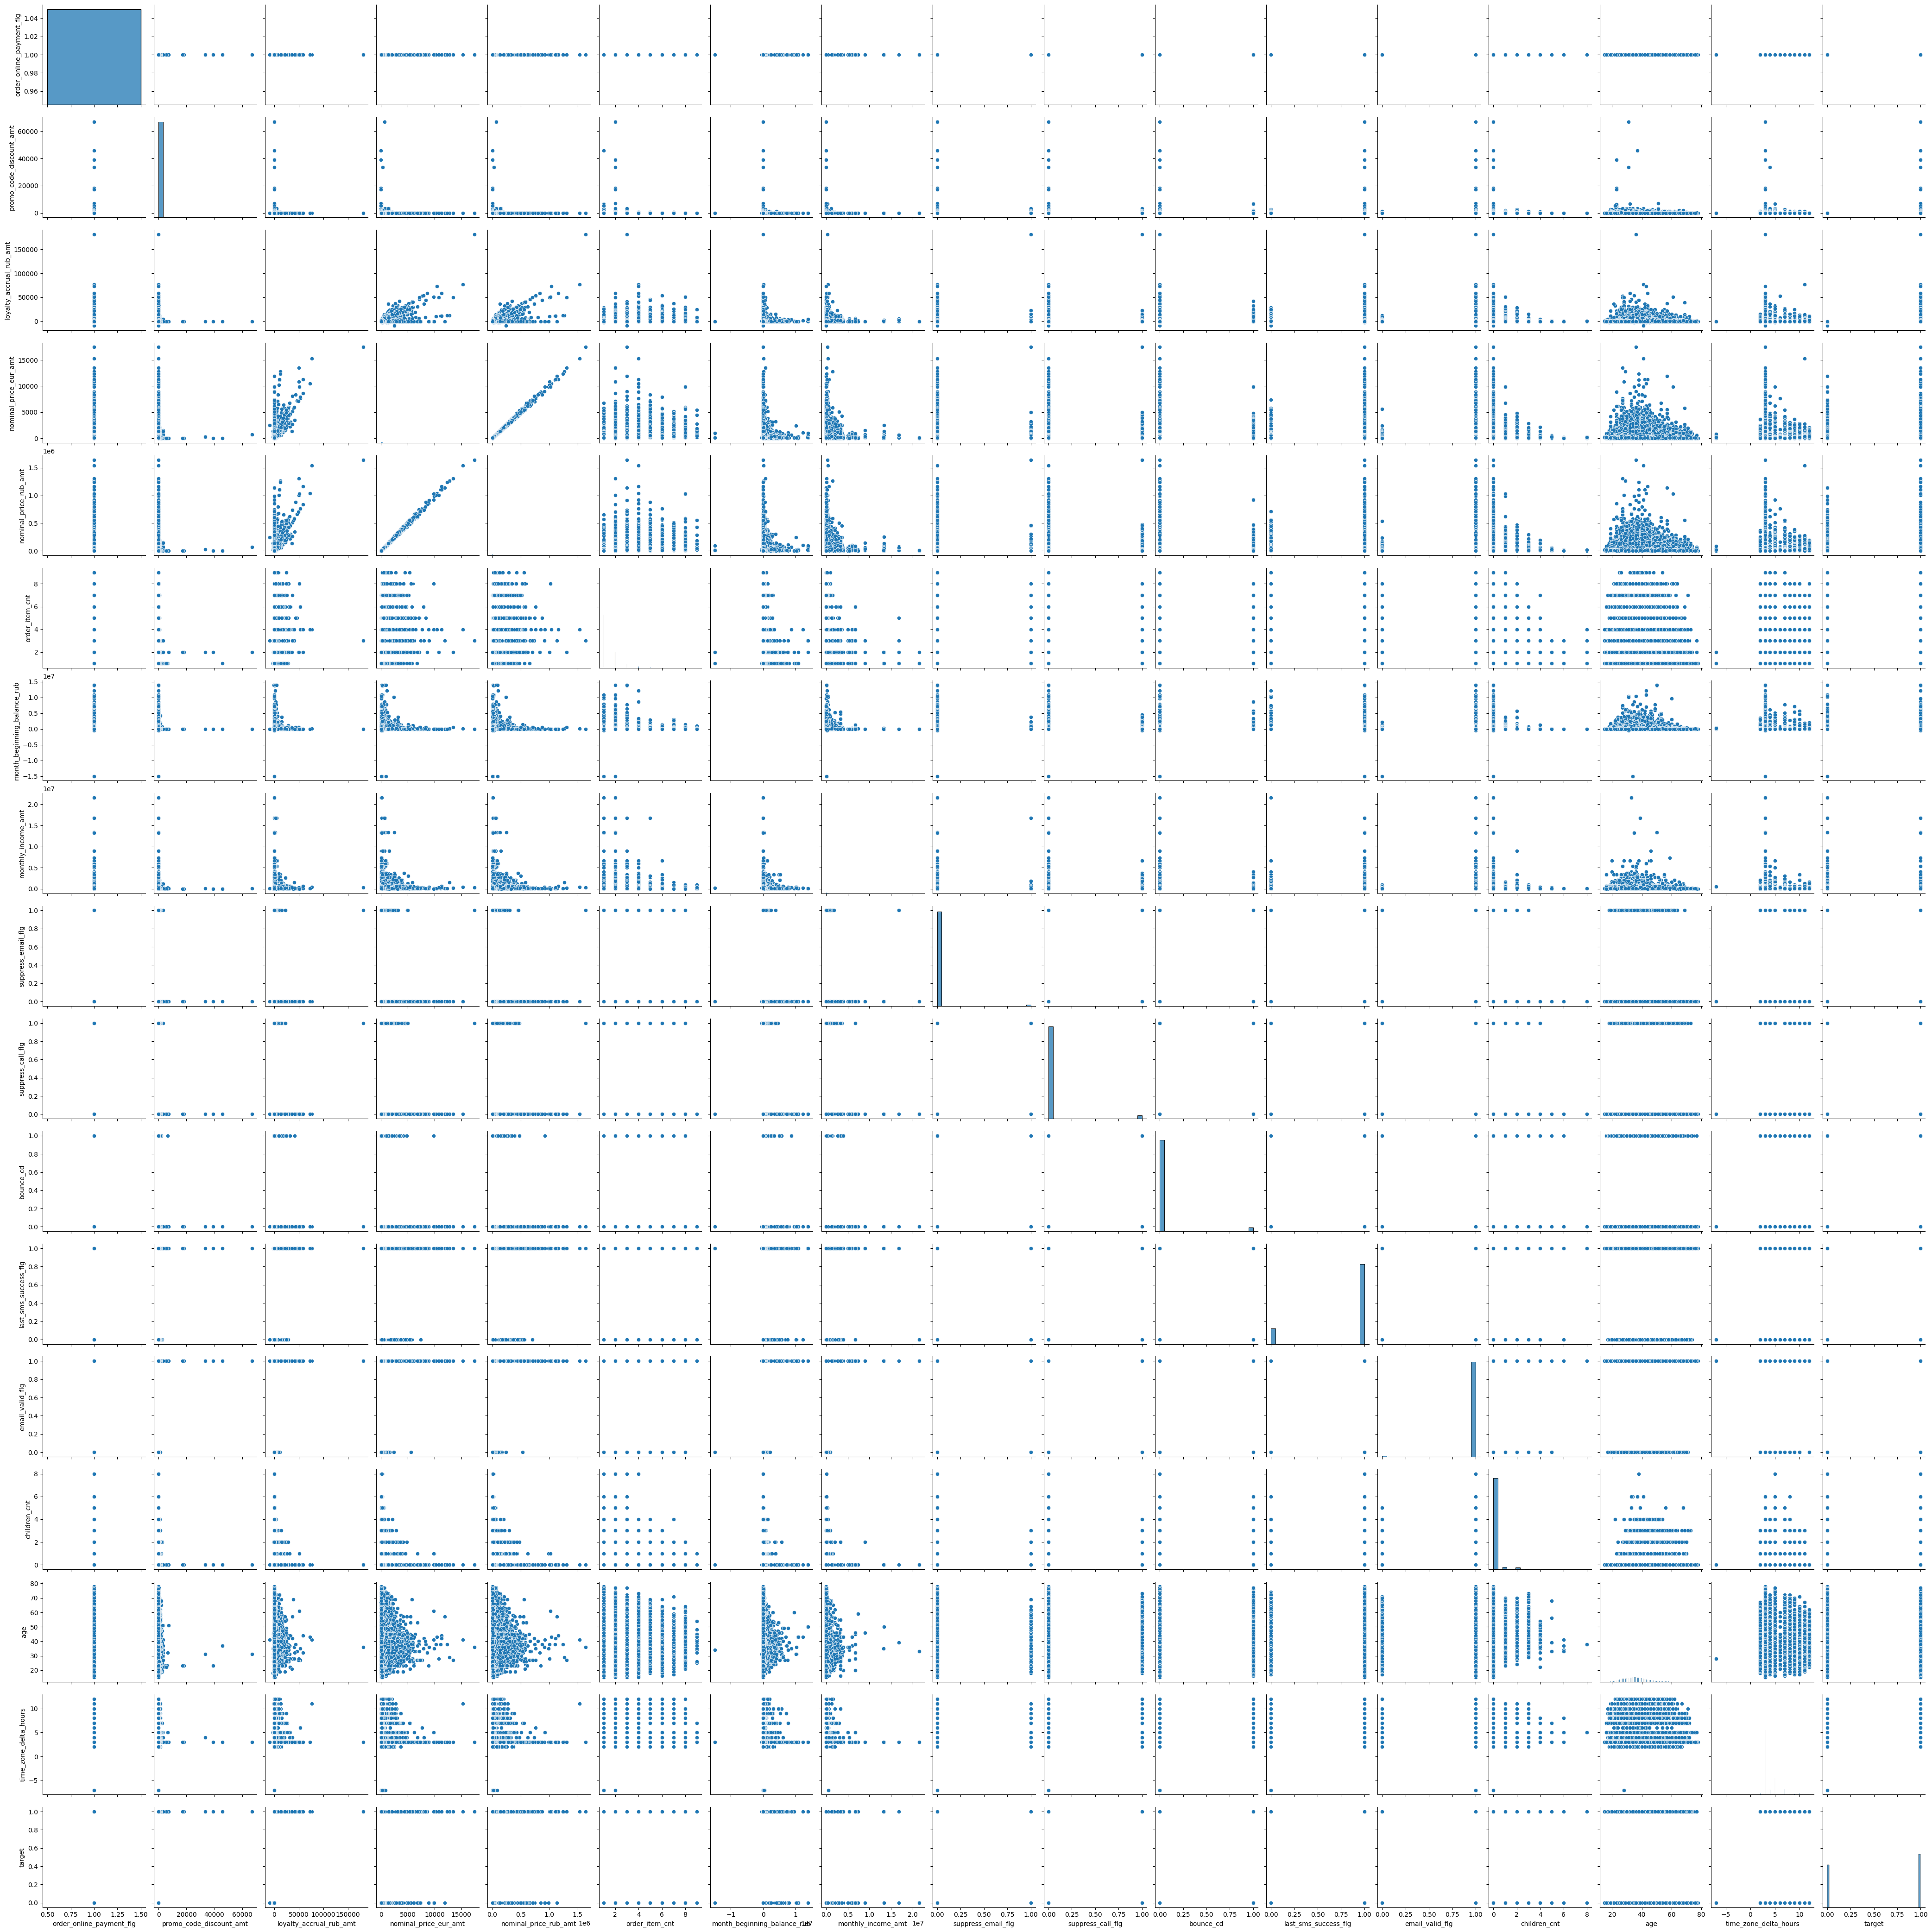

In [31]:
sns.pairplot(df_cleaned)
plt.show()

# Мат модель, пред анализ.

### Обучим несколько моделей регрессии, для выявления линейных зависимостей, проверки стат значимости и проверки гепотез.
### После обучим модель <b>градиентного бустинга CatBoost</b> для выявления возможных нелинейных зависимостей

## Линейные модели:

### Импорт модели 

In [23]:
import statsmodels.api as sm

#### Базовая линейная модель на всех данных

In [24]:
Y = df_cleaned['loyalty_accrual_rub_amt']

X = df_cleaned['nominal_price_eur_amt']

X = sm.add_constant(X)

model = sm.OLS(Y, X).fit()

In [60]:
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               OLS Regression Results                              
===================================================================================
Dep. Variable:     loyalty_accrual_rub_amt   R-squared:                       0.384
Model:                                 OLS   Adj. R-squared:                  0.384
Method:                      Least Squares   F-statistic:                 4.315e+05
Date:                     Mon, 12 May 2025   Prob (F-statistic):               0.00
Time:                             13:33:05   Log-Likelihood:            -5.5887e+06
No. Observations:                   693551   AIC:                         1.118e+07
Df Residuals:                       693549   BIC:                         1.118e+07
Df Model:                                1                                         
Covariance Type:                 nonrobust                                         
=========================================================================================
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
const                   -19.9254      1.098    -18.153      0.000     -22.077     -17.774
nominal_price_eur_amt     2.6047      0.004    656.875      0.000       2.597       2.612
==============================================================================
Omnibus:                   702570.668   Durbin-Watson:                   1.995
Prob(Omnibus):                  0.000   Jarque-Bera (JB):       1071374593.154
Skew:                           3.935   Prob(JB):                         0.00
Kurtosis:                     195.386   Cond. No.                         331.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

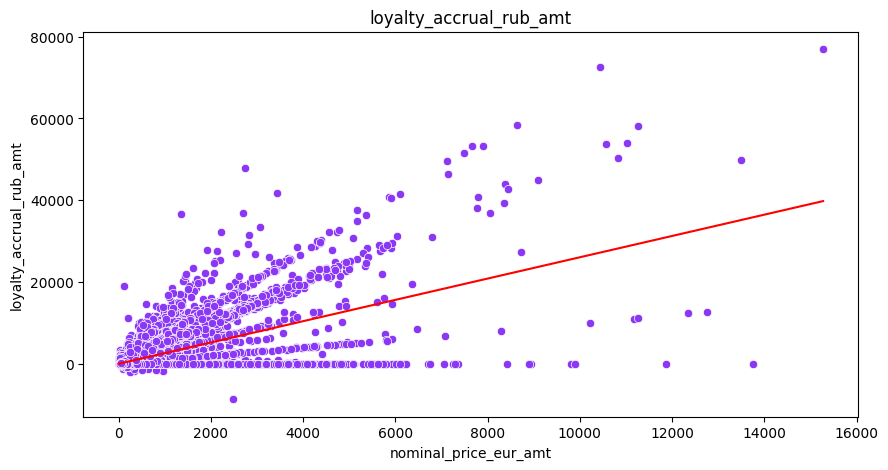

In [35]:
plt.figure(figsize=(10, 5))
plt.subplot(1, 1, 1)  
sns.scatterplot(x=df_cleaned['nominal_price_eur_amt'], y=df_cleaned['loyalty_accrual_rub_amt'], color='#8A38F5')
sns.lineplot(x=df_cleaned['nominal_price_eur_amt'], y=model.predict(X), color='red')
plt.title('loyalty_accrual_rub_amt') 
plt.show()

#### Модель на данных, в которых люди получали бонусы по лояльности в целом

In [61]:
df_lol = df_cleaned[df_cleaned['loyalty_accrual_rub_amt'] > 0]

print(len(df_lol), len(df_cleaned), len(df_lol) / len(df_cleaned) * 100)

Y = df_lol['loyalty_accrual_rub_amt'] 

X = df_lol['nominal_price_eur_amt']

X = sm.add_constant(X)

model = sm.OLS(Y, X).fit()

model.summary()

410093 693551 59.12946560526912


<class 'statsmodels.iolib.summary.Summary'>
"""
                               OLS Regression Results                              
===================================================================================
Dep. Variable:     loyalty_accrual_rub_amt   R-squared:                       0.708
Model:                                 OLS   Adj. R-squared:                  0.708
Method:                      Least Squares   F-statistic:                 9.928e+05
Date:                     Mon, 12 May 2025   Prob (F-statistic):               0.00
Time:                             13:33:12   Log-Likelihood:            -3.2370e+06
No. Observations:                   410093   AIC:                         6.474e+06
Df Residuals:                       410091   BIC:                         6.474e+06
Df Model:                                1                                         
Covariance Type:                 nonrobust                                         
=========================================================================================
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
const                   -12.0828      1.203    -10.045      0.000     -14.440      -9.725
nominal_price_eur_amt     4.2962      0.004    996.370      0.000       4.288       4.305
==============================================================================
Omnibus:                   225119.367   Durbin-Watson:                   1.998
Prob(Omnibus):                  0.000   Jarque-Bera (JB):       1849345618.404
Skew:                          -0.764   Prob(JB):                         0.00
Kurtosis:                     331.979   Cond. No.                         331.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

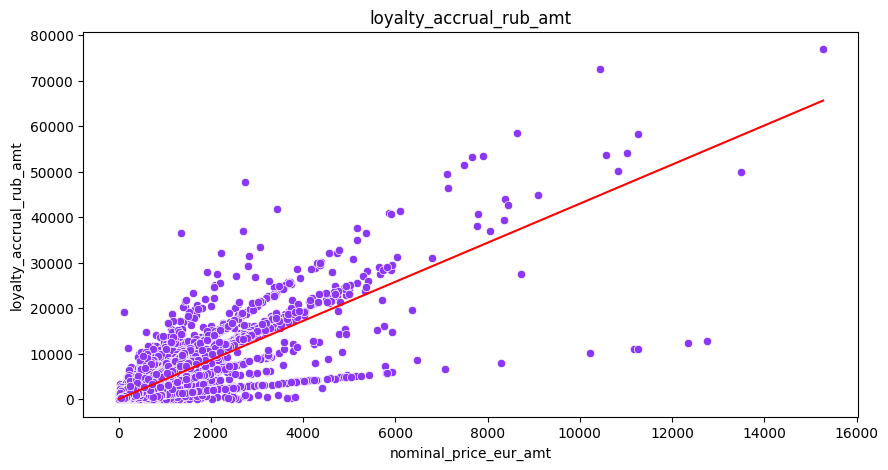

In [41]:
plt.figure(figsize=(10, 5))
plt.subplot(1, 1, 1)  
sns.scatterplot(x=df_lol['nominal_price_eur_amt'], y=df_lol['loyalty_accrual_rub_amt'], color='#8A38F5')
sns.lineplot(x=df_lol['nominal_price_eur_amt'], y=model.predict(X), color='red')
plt.title('loyalty_accrual_rub_amt') 
plt.show()

#### Проверка результатов по подгруппам

In [62]:
df_lol = df_lol[df_lol['order_type_cd'] == "AIR"]
print(len(df_lol), len(df_cleaned), len(df_lol) / len(df_cleaned) * 100)

319379 693551 46.04982185881067


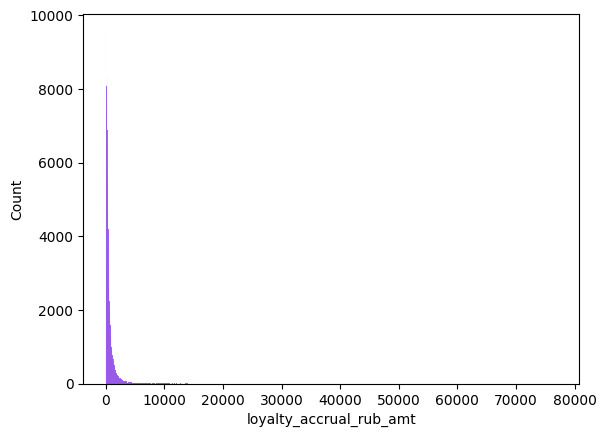

In [44]:
sns.histplot(df_lol['loyalty_accrual_rub_amt'], color="#8A38F5")
plt.show()

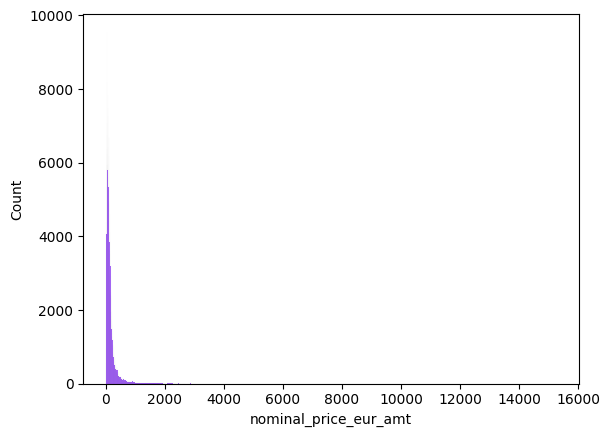

In [45]:
sns.histplot(df_lol['nominal_price_eur_amt'], color="#8A38F5")
plt.show()

In [46]:
Y = df_lol['loyalty_accrual_rub_amt'] 

X = df_lol['nominal_price_eur_amt']

X = sm.add_constant(X)

model = sm.OLS(Y, X).fit()

model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               OLS Regression Results                              
===================================================================================
Dep. Variable:     loyalty_accrual_rub_amt   R-squared:                       0.841
Model:                                 OLS   Adj. R-squared:                  0.841
Method:                      Least Squares   F-statistic:                 1.685e+06
Date:                     Mon, 12 May 2025   Prob (F-statistic):               0.00
Time:                             03:41:22   Log-Likelihood:            -2.4465e+06
No. Observations:                   319379   AIC:                         4.893e+06
Df Residuals:                       319377   BIC:                         4.893e+06
Df Model:                                1                                         
Covariance Type:                 nonrobust                                         
=========================================================================================
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
const                   -90.5870      1.098    -82.503      0.000     -92.739     -88.435
nominal_price_eur_amt     4.9403      0.004   1298.001      0.000       4.933       4.948
==============================================================================
Omnibus:                   175901.150   Durbin-Watson:                   1.997
Prob(Omnibus):                  0.000   Jarque-Bera (JB):        696289032.905
Skew:                           0.907   Prob(JB):                         0.00
Kurtosis:                     231.735   Cond. No.                         349.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

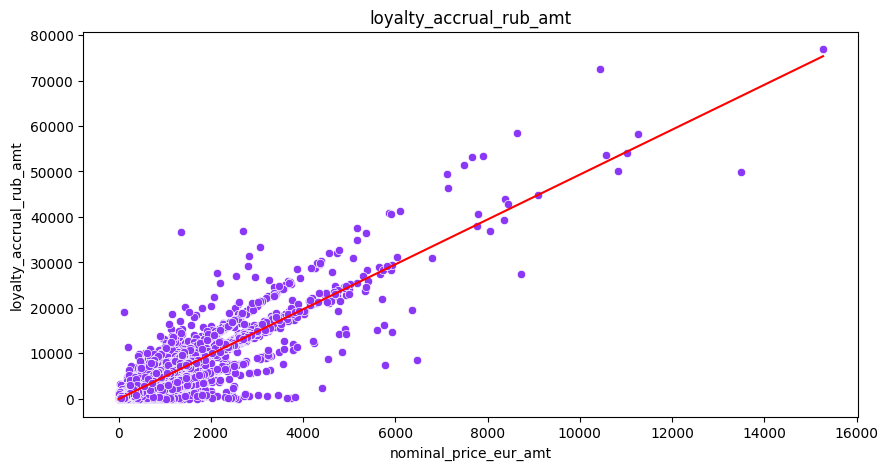

In [47]:
plt.figure(figsize=(10, 5))
plt.subplot(1, 1, 1)  
sns.scatterplot(x=df_lol['nominal_price_eur_amt'], y=df_lol['loyalty_accrual_rub_amt'], color='#8A38F5')
sns.lineplot(x=df_lol['nominal_price_eur_amt'], y=model.predict(X), color='red')
plt.title('loyalty_accrual_rub_amt') 
plt.show()

In [48]:
Y = df_lol['promo_code_discount_amt'] 

X = df_lol['nominal_price_eur_amt']

X = sm.add_constant(X)

model = sm.OLS(Y, X).fit()

model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               OLS Regression Results                              
===================================================================================
Dep. Variable:     promo_code_discount_amt   R-squared:                       0.000
Model:                                 OLS   Adj. R-squared:                  0.000
Method:                      Least Squares   F-statistic:                     7.018
Date:                     Mon, 12 May 2025   Prob (F-statistic):            0.00807
Time:                             03:43:43   Log-Likelihood:            -1.9603e+06
No. Observations:                   319379   AIC:                         3.921e+06
Df Residuals:                       319377   BIC:                         3.921e+06
Df Model:                                1                                         
Covariance Type:                 nonrobust                                         
=========================================================================================
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
const                     4.6595      0.240     19.451      0.000       4.190       5.129
nominal_price_eur_amt    -0.0022      0.001     -2.649      0.008      -0.004      -0.001
==============================================================================
Omnibus:                  1649775.861   Durbin-Watson:                   2.001
Prob(Omnibus):                  0.000   Jarque-Bera (JB):   74714712512091.500
Skew:                         242.525   Prob(JB):                         0.00
Kurtosis:                   74931.391   Cond. No.                         349.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

Теперь по подгруппе отелей

In [49]:
df_lol = df_cleaned[df_cleaned['loyalty_accrual_rub_amt'] > 0]

df_lol = df_lol[df_lol['order_type_cd'] == "HOT"]
print(len(df_lol), len(df_cleaned), len(df_lol) / len(df_cleaned) * 100)

90714 693551 13.079643746458444


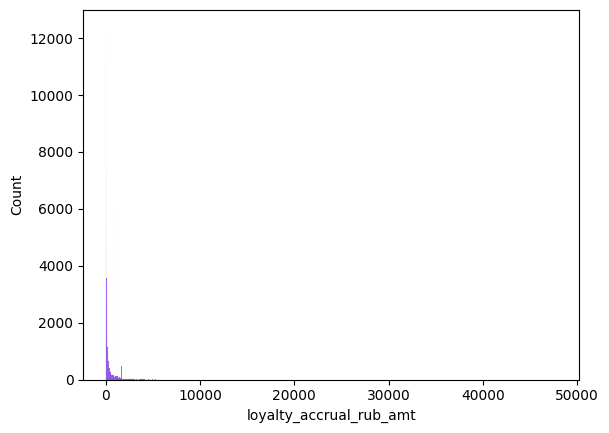

In [50]:
sns.histplot(df_lol['loyalty_accrual_rub_amt'], color="#8A38F5")
plt.show()

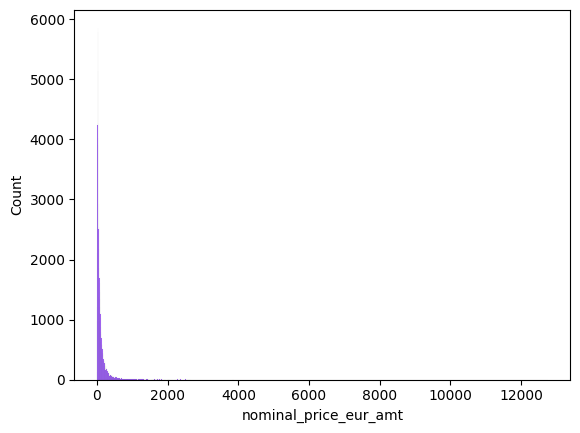

In [51]:
sns.histplot(df_lol['nominal_price_eur_amt'], color="#8A38F5")
plt.show()

In [52]:
Y = df_lol['loyalty_accrual_rub_amt'] 

X = df_lol['nominal_price_eur_amt']

X = sm.add_constant(X)

model = sm.OLS(Y, X).fit()

model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               OLS Regression Results                              
===================================================================================
Dep. Variable:     loyalty_accrual_rub_amt   R-squared:                       0.159
Model:                                 OLS   Adj. R-squared:                  0.159
Method:                      Least Squares   F-statistic:                 1.718e+04
Date:                     Mon, 12 May 2025   Prob (F-statistic):               0.00
Time:                             03:46:20   Log-Likelihood:            -7.2318e+05
No. Observations:                    90714   AIC:                         1.446e+06
Df Residuals:                        90712   BIC:                         1.446e+06
Df Model:                                1                                         
Covariance Type:                 nonrobust                                         
=========================================================================================
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
const                   216.8009      2.619     82.767      0.000     211.667     221.935
nominal_price_eur_amt     1.4159      0.011    131.080      0.000       1.395       1.437
==============================================================================
Omnibus:                   156513.272   Durbin-Watson:                   2.009
Prob(Omnibus):                  0.000   Jarque-Bera (JB):        613842986.274
Skew:                          11.539   Prob(JB):                         0.00
Kurtosis:                     405.331   Cond. No.                         273.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

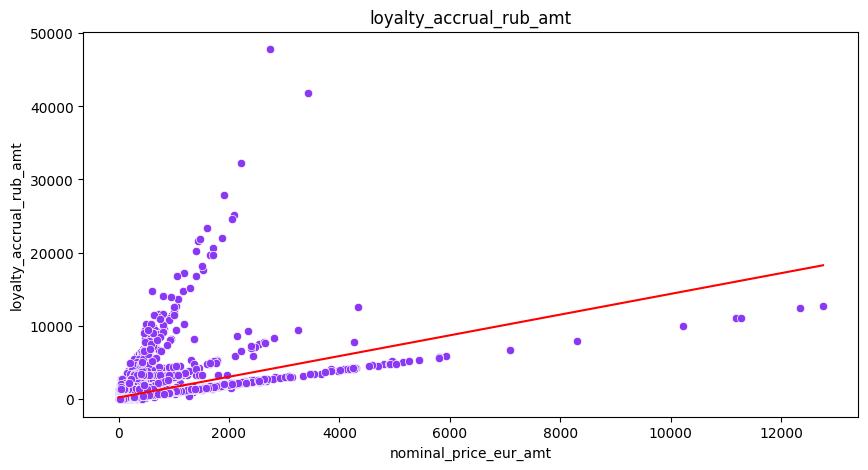

In [53]:
plt.figure(figsize=(10, 5))
plt.subplot(1, 1, 1)  
sns.scatterplot(x=df_lol['nominal_price_eur_amt'], y=df_lol['loyalty_accrual_rub_amt'], color='#8A38F5')
sns.lineplot(x=df_lol['nominal_price_eur_amt'], y=model.predict(X), color='red')
plt.title('loyalty_accrual_rub_amt') 
plt.show()

In [23]:
df_lol = df_cleaned[df_cleaned['loyalty_accrual_rub_amt'] > 0]

df_lol = df_lol[df_lol['order_type_cd'] == "AIR"]
print(len(df_lol), len(df_cleaned), len(df_lol) / len(df_cleaned) * 100)

Y = df_lol['loyalty_accrual_rub_amt'] 

X = df_lol['nominal_price_eur_amt']

X = sm.add_constant(X)

model = sm.OLS(Y, X).fit()

model.summary()

224307 543988 41.23381398119076


<class 'statsmodels.iolib.summary.Summary'>
"""
                               OLS Regression Results                              
===================================================================================
Dep. Variable:     loyalty_accrual_rub_amt   R-squared:                       0.841
Model:                                 OLS   Adj. R-squared:                  0.841
Method:                      Least Squares   F-statistic:                 1.185e+06
Date:                     Tue, 13 May 2025   Prob (F-statistic):               0.00
Time:                             02:29:53   Log-Likelihood:            -1.7240e+06
No. Observations:                   224307   AIC:                         3.448e+06
Df Residuals:                       224305   BIC:                         3.448e+06
Df Model:                                1                                         
Covariance Type:                 nonrobust                                         
=========================================================================================
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
const                   -69.6202      1.336    -52.111      0.000     -72.239     -67.002
nominal_price_eur_amt     4.9724      0.005   1088.660      0.000       4.963       4.981
==============================================================================
Omnibus:                   112950.010   Durbin-Watson:                   1.999
Prob(Omnibus):                  0.000   Jarque-Bera (JB):        562681575.976
Skew:                           0.591   Prob(JB):                         0.00
Kurtosis:                     248.364   Cond. No.                         351.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

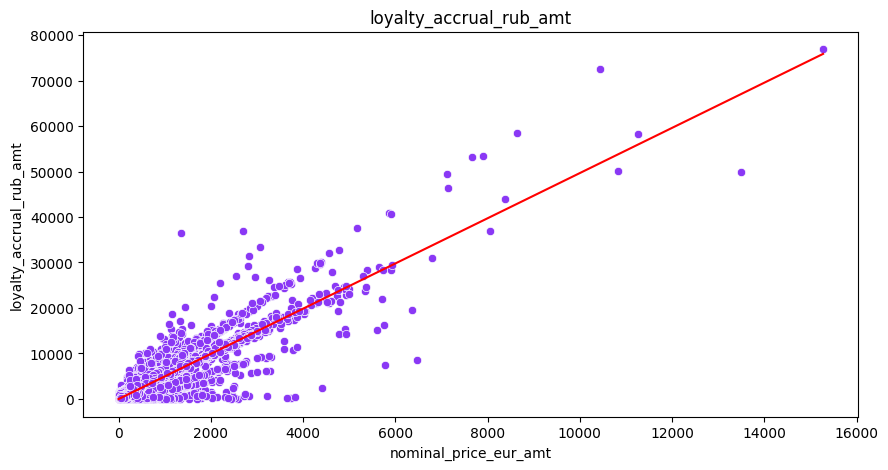

In [24]:
plt.figure(figsize=(10, 5))
plt.subplot(1, 1, 1)  
sns.scatterplot(x=df_lol['nominal_price_eur_amt'], y=df_lol['loyalty_accrual_rub_amt'], color='#8A38F5')
sns.lineplot(x=df_lol['nominal_price_eur_amt'], y=model.predict(X), color='red')
plt.title('loyalty_accrual_rub_amt') 
plt.show()

#### Выявляем линейные зависимости от возраста

In [46]:
Y = df_cleaned['loyalty_accrual_rub_amt']

X_AGE = df_cleaned['age']

X_AGE = sm.add_constant(X_AGE)

model = sm.OLS(Y, X_AGE).fit()

model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               OLS Regression Results                              
===================================================================================
Dep. Variable:     loyalty_accrual_rub_amt   R-squared:                       0.000
Model:                                 OLS   Adj. R-squared:                  0.000
Method:                      Least Squares   F-statistic:                     10.05
Date:                     Fri, 09 May 2025   Prob (F-statistic):            0.00152
Time:                             06:34:00   Log-Likelihood:            -5.7564e+06
No. Observations:                   693551   AIC:                         1.151e+07
Df Residuals:                       693549   BIC:                         1.151e+07
Df Model:                                1                                         
Covariance Type:                 nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        391.5000      5.202     75.264      0.000     381.305     401.695
age           -0.4481      0.141     -3.170      0.002      -0.725      -0.171
==============================================================================
Omnibus:                  1282213.573   Durbin-Watson:                   1.997
Prob(Omnibus):                  0.000   Jarque-Bera (JB):       5445052379.350
Skew:                          13.516   Prob(JB):                         0.00
Kurtosis:                     436.235   Cond. No.                         164.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [47]:
Y_PROMO = df_cleaned['promo_code_discount_amt']

X_AGE = df_cleaned['age']

X_AGE = sm.add_constant(X_AGE)

model = sm.OLS(Y, X_AGE).fit()

model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               OLS Regression Results                              
===================================================================================
Dep. Variable:     loyalty_accrual_rub_amt   R-squared:                       0.000
Model:                                 OLS   Adj. R-squared:                  0.000
Method:                      Least Squares   F-statistic:                     10.05
Date:                     Fri, 09 May 2025   Prob (F-statistic):            0.00152
Time:                             06:34:05   Log-Likelihood:            -5.7564e+06
No. Observations:                   693551   AIC:                         1.151e+07
Df Residuals:                       693549   BIC:                         1.151e+07
Df Model:                                1                                         
Covariance Type:                 nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        391.5000      5.202     75.264      0.000     381.305     401.695
age           -0.4481      0.141     -3.170      0.002      -0.725      -0.171
==============================================================================
Omnibus:                  1282213.573   Durbin-Watson:                   1.997
Prob(Omnibus):                  0.000   Jarque-Bera (JB):       5445052379.350
Skew:                          13.516   Prob(JB):                         0.00
Kurtosis:                     436.235   Cond. No.                         164.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

Мы получили одну стат значимую модель, которая объясняет ~40% данных, что в целом приемлимо для экономической задачи, как у нас, и две модели не имеющие никакой линейной зависимости, из-за r^2 = 0, однако мы еще можем проверить нашу гепотезу с помощью CatBoost

### CatBoost

In [33]:
df_lol = df_cleaned[df_cleaned['order_type_cd'] == "AIR"].copy()

In [35]:
drop_columns = [
    'party_first_order_dt',
    'book_start_dttm', 'local_book_start_dttm', 'last_session_dttm',
    'nominal_price_eur_amt', 'nominal_price_rub_amt', 'loyalty_accrual_rub_amt'
]

In [36]:
df_lol['created_dttm'] = pd.to_datetime(df_lol['created_dttm'])

df_lol['year'] = df_lol['created_dttm'].dt.year
df_lol['month'] = df_lol['created_dttm'].dt.month
df_lol['dayofweek'] = df_lol['created_dttm'].dt.dayofweek 
df_lol['quarter'] = df_lol['created_dttm'].dt.quarter 

df_lol = df_lol.drop('created_dttm', axis=1)

In [37]:
Y = df_lol['nominal_price_eur_amt']

df_lol.drop(drop_columns, axis=1, inplace=True)

X = df_lol

In [38]:
cat_features = X.select_dtypes(include=object).columns.to_list()

model = CatBoostRegressor(
    iterations=1000,
    learning_rate=0.1,
    depth=8,
    cat_features=cat_features
)

model.fit(X, Y)

0:	learn: 226.7835272	total: 584ms	remaining: 9m 43s
1:	learn: 218.1541099	total: 1.05s	remaining: 8m 42s
2:	learn: 210.8541057	total: 1.44s	remaining: 7m 57s
3:	learn: 204.4844019	total: 1.79s	remaining: 7m 26s
4:	learn: 199.0694002	total: 2.2s	remaining: 7m 18s
5:	learn: 194.5037934	total: 2.62s	remaining: 7m 14s
6:	learn: 190.6628752	total: 3.03s	remaining: 7m 9s
7:	learn: 187.5085834	total: 3.46s	remaining: 7m 8s
8:	learn: 184.7905425	total: 3.84s	remaining: 7m 3s
9:	learn: 182.4588465	total: 4.25s	remaining: 7m
10:	learn: 180.4544324	total: 4.65s	remaining: 6m 57s
11:	learn: 178.8526930	total: 5.09s	remaining: 6m 58s
12:	learn: 177.3177881	total: 5.5s	remaining: 6m 57s
13:	learn: 176.0365890	total: 5.97s	remaining: 7m
14:	learn: 174.9100145	total: 6.44s	remaining: 7m 3s
15:	learn: 173.9228197	total: 6.84s	remaining: 7m 1s
16:	learn: 173.0137154	total: 7.29s	remaining: 7m 1s
17:	learn: 172.1545370	total: 7.81s	remaining: 7m 6s
18:	learn: 171.4007931	total: 8.28s	remaining: 7m 7s
19

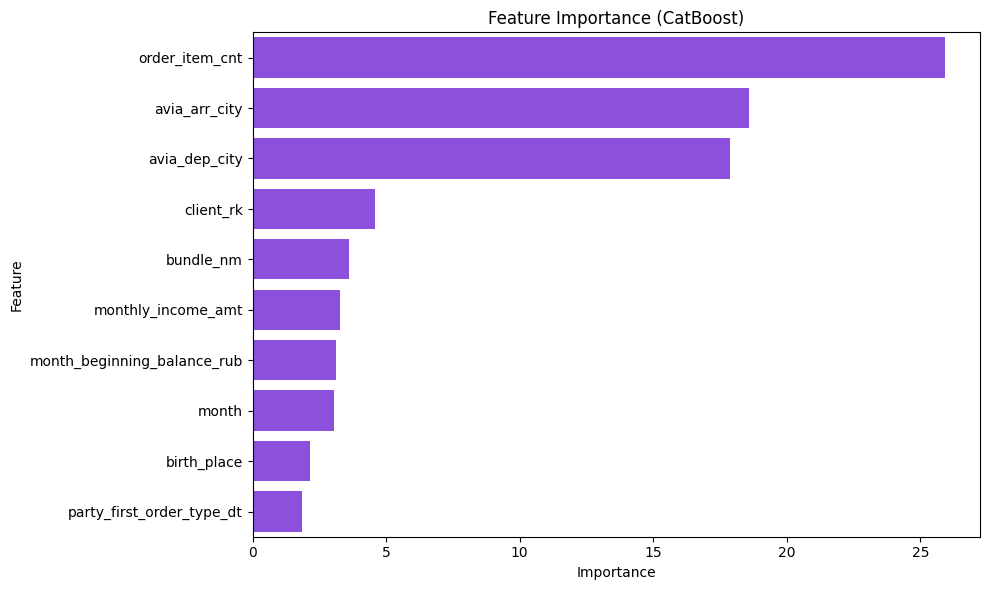

In [62]:
importances = model.get_feature_importance()
features = X.columns

feature_importance_df = pd.DataFrame({
    'Feature': features,
    'Importance': importances
}).sort_values(by='Importance', ascending=False).head(10)

plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=feature_importance_df, color="#8A38F5")
plt.title('Feature Importance (CatBoost)')
plt.tight_layout()
plt.show()

In [57]:
df_lol['marital_status_cd'].value_counts()

marital_status_cd
MAR    151221
UNM    146530
UNK     82834
CIV     23025
DIV     22320
WID      1073
DLW         5
Name: count, dtype: int64

# Обработка расстояния

In [28]:
from geopy.geocoders import Nominatim
import time
import json

In [ ]:
unique_cities = pd.concat([df_lol['avia_dep_city'], df_lol['avia_arr_city']]).unique()

geolocator = Nominatim(user_agent="flight_distance_calculator")
city_coords = {}

for city in unique_cities:
    try:
        location = geolocator.geocode(city)
        city_coords[city] = (location.latitude, location.longitude)
        time.sleep(1) 
    except:
        city_coords[city] = None

with open('city_coordinates.json', 'w') as f:
    json.dump(city_coords, f)

In [34]:
with open('city_coordinates.json', 'r') as f:
    city_coords = json.load(f)
df_lol['dep_coords'] = df_lol['avia_dep_city'].map(city_coords)
df_lol['arr_coords'] = df_lol['avia_arr_city'].map(city_coords)

In [36]:
from geopy.distance import geodesic

df_lol['distance_km'] = df_lol.apply(
    lambda row: geodesic(row['dep_coords'], row['arr_coords']).km 
    if row['dep_coords'] and row['arr_coords'] else None, 
    axis=1
)

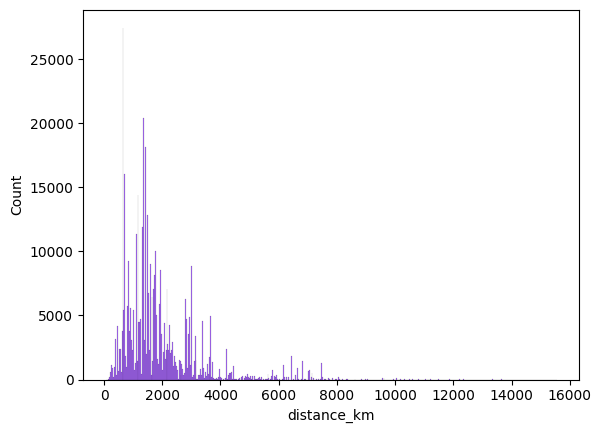

In [37]:
sns.histplot(df_lol['distance_km'], color='#8A38F5')
plt.show()

In [43]:
df_lol.dropna(inplace=True)

<function matplotlib.pyplot.show(close=None, block=None)>

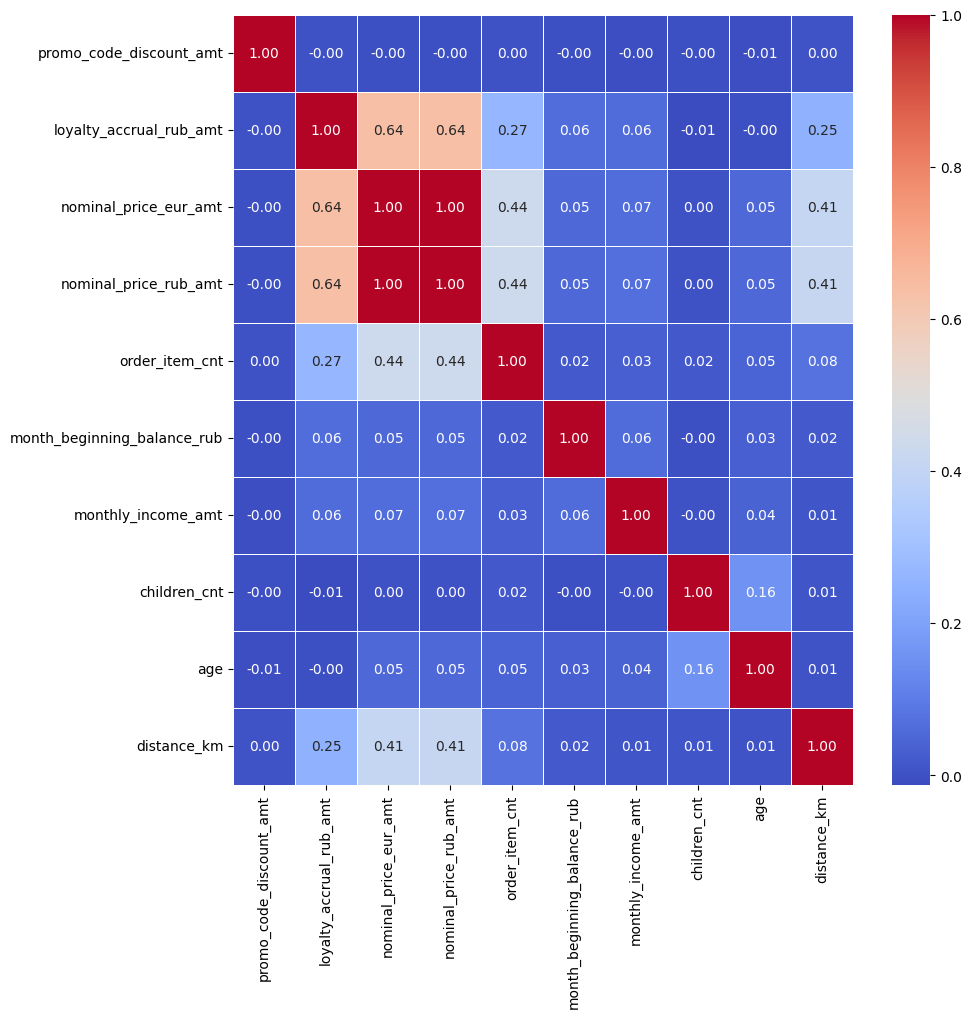

In [44]:
n_df = df_lol.select_dtypes(include=np.number)
n_df.drop(['order_online_payment_flg', 'suppress_email_flg', 'suppress_call_flg', 'bounce_cd', 'last_sms_success_flg', 'email_valid_flg'], axis=1, inplace=True)
corr = n_df.corr()
plt.figure(figsize=(10, 10))
sns.heatmap(corr, annot=True, fmt=".2f", linewidths=0.5, cmap='coolwarm')
plt.show

In [ ]:
import folium
import numpy as np

dep_counts = df_cleaned['avia_dep_city'].value_counts().reset_index()
dep_counts.columns = ['city', 'count']
# arr_counts = df_cleaned['avia_arr_city'].value_counts().reset_index()
# arr_counts.columns = ['city', 'count']

m = folium.Map(location=[30, 10], zoom_start=2)

def add_circles(data, color, prefix):
    for _, row in data.iterrows():
        city = row['city']
        coords = city_coords.get(city)
        if coords:
            radius = np.log(np.log(row['count'] + 1) * 2) * 2
            
            folium.CircleMarker(
                location=coords,
                radius=radius,
                color=color,
                fill=True,
                fill_color=color,
                fill_opacity=0.6,
                tooltip=f"{prefix} {city}: {row['count']}"
            ).add_to(m)

add_circles(dep_counts, 'red', 'Вылетов из')
# add_circles(arr_counts, 'blue', 'Прилетов в')

m.save('from_points_map.html')

In [50]:
Y = df_lol['nominal_price_rub_amt'] // 1000

X = df_lol['distance_km']

X = sm.add_constant(X)

model = sm.OLS(Y, X).fit()

model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                              OLS Regression Results                             
=================================================================================
Dep. Variable:     nominal_price_rub_amt   R-squared:                       0.170
Model:                               OLS   Adj. R-squared:                  0.170
Method:                    Least Squares   F-statistic:                 8.711e+04
Date:                   Tue, 13 May 2025   Prob (F-statistic):               0.00
Time:                           12:05:53   Log-Likelihood:            -1.9104e+06
No. Observations:                 426604   AIC:                         3.821e+06
Df Residuals:                     426602   BIC:                         3.821e+06
Df Model:                              1                                         
Covariance Type:               nonrobust                                         
===============================================================================
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const           2.0372      0.056     36.425      0.000       1.928       2.147
distance_km     0.0072   2.45e-05    295.142      0.000       0.007       0.007
==============================================================================
Omnibus:                   686021.154   Durbin-Watson:                   2.002
Prob(Omnibus):                  0.000   Jarque-Bera (JB):       1363887209.338
Skew:                          10.133   Prob(JB):                         0.00
Kurtosis:                     279.259   Cond. No.                     3.92e+03
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 3.92e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

модель получилась мало значимой

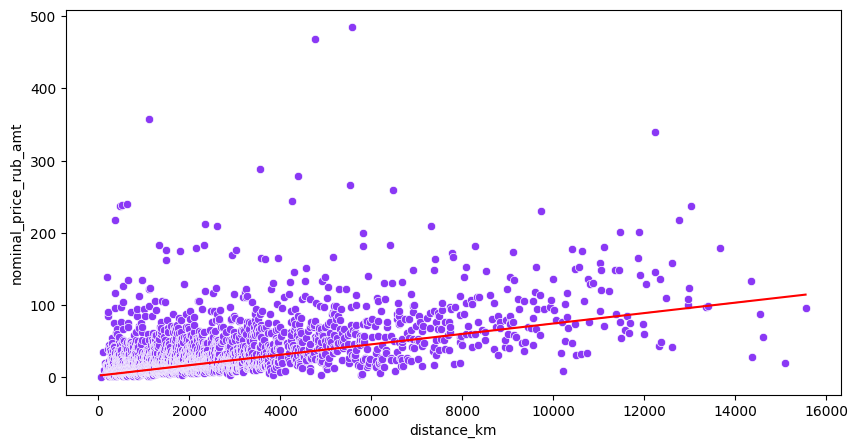

In [51]:
grouped = df_lol.groupby('distance_km')['nominal_price_rub_amt'].mean().reset_index()
grouped['nominal_price_rub_amt'] = grouped['nominal_price_rub_amt'] // 1000

plt.figure(figsize=(10, 5))
sns.scatterplot(x=grouped['distance_km'], y=grouped['nominal_price_rub_amt'], color='#8A38F5')
sns.lineplot(x=df_lol['distance_km'], y=model.predict(X), color='red')
plt.show()

In [52]:
df_lol.columns

Index(['order_online_payment_flg', 'account_rk', 'client_rk', 'order_rk',
       'bundle_nm', 'order_type_cd', 'order_status_cd', 'party_first_order_dt',
       'party_first_order_type_dt', 'created_dttm', 'book_start_dttm',
       'local_book_start_dttm', 'book_end_dttm', 'hotel_country', 'hotel_city',
       'avia_dep_city', 'avia_arr_city', 'promo_code_discount_amt',
       'loyalty_accrual_rub_amt', 'nominal_price_eur_amt',
       'nominal_price_rub_amt', 'order_item_cnt',
       'month_beginning_balance_rub', 'monthly_income_amt',
       'suppress_email_flg', 'suppress_call_flg', 'bounce_cd',
       'last_sms_success_flg', 'email_valid_flg', 'children_cnt', 'age',
       'age_type_cd', 'delivery_region_category_cd', 'lvn_state_nm',
       'time_zone_delta_tm', 'time_zone_cd', 'last_used_product_cd',
       'first_used_product_cd', 'mobile_phone_operator_nm',
       'marital_status_cd', 'education_level_cd', 'birth_place', 'gender_cd',
       'last_sms_dt', 'last_session_dttm', 'lo

/tmp/ipykernel_184108/1259137048.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_expensive_cities.values, y=top_expensive_cities.index, palette='viridis')


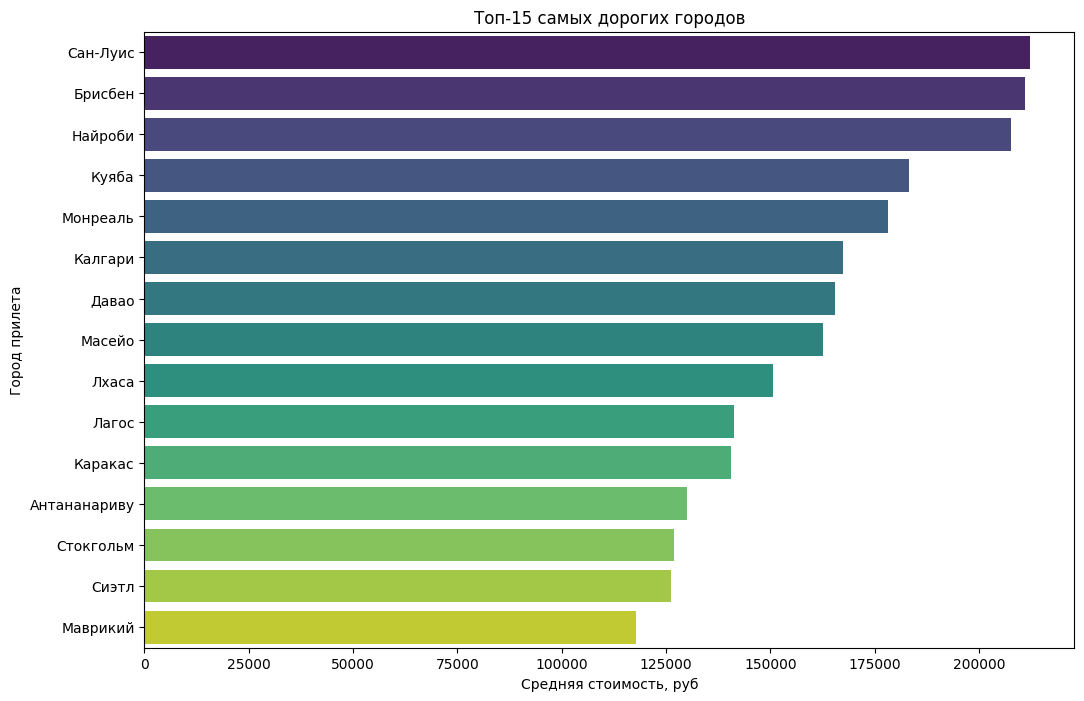

In [54]:
top_expensive_cities = df_lol.groupby('avia_arr_city')['nominal_price_rub_amt'].mean().sort_values(ascending=False).head(15)

plt.figure(figsize=(12, 8))
sns.barplot(x=top_expensive_cities.values, y=top_expensive_cities.index, palette='viridis')
plt.title('Топ-15 самых дорогих городов')
plt.xlabel('Средняя стоимость, руб')
plt.ylabel('Город прилета')
plt.show()

# Проверка гепотезы

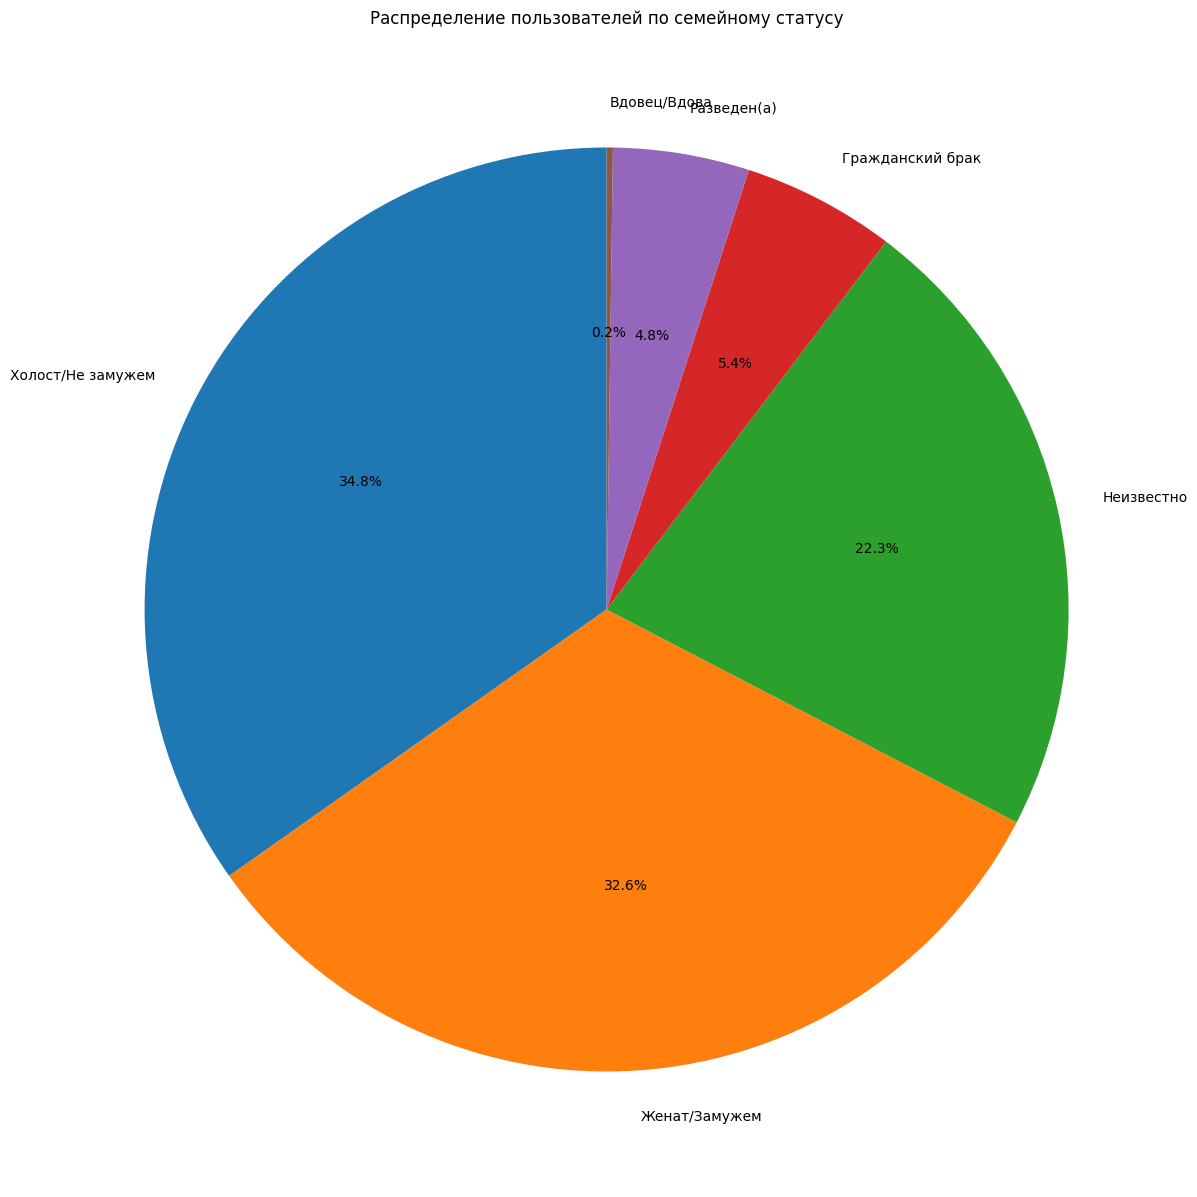

In [24]:
marital_status_labels = {
    'MAR': 'Женат/Замужем',
    'OMR': 'Зарегистрированный брак',
    'CIV': 'Гражданский брак',
    'UNM': 'Холост/Не замужем',
    'DIV': 'Разведен(а)',
    'FAL': 'Никогда не состоял(а) в браке',
    'WID': 'Вдовец/Вдова',
    'IMR': 'Незарегистрированный брак',
    'DLW': 'Не проживает с супругом(ой)',
    'UNK': 'Неизвестно'
}

# Заменяем коды на понятные названия
df_lol['marital_status'] = df_lol['marital_status_cd'].map(marital_status_labels)

# Группировка и подсчет
marital_distribution = df_lol['marital_status'].value_counts(normalize=True) * 100

# Построение круговой диаграммы
plt.figure(figsize=(15, 15))
marital_distribution.plot.pie(autopct='%1.1f%%', startangle=90)
plt.title('Распределение пользователей по семейному статусу')
plt.ylabel('')
plt.show()

/tmp/ipykernel_389187/3733841352.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=price_comparison.index, y=price_comparison.values, palette='pastel')


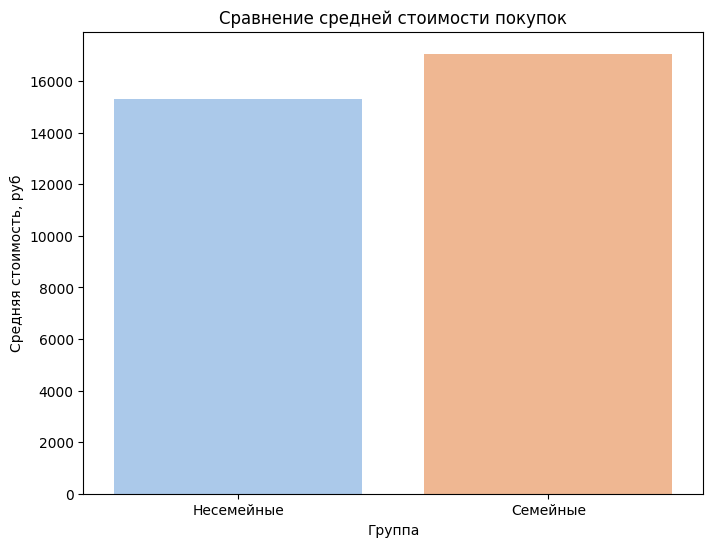

In [25]:
married = ['Женат/Замужем', 'Зарегистрированный брак', 'Гражданский брак']
df_lol['is_married'] = df_lol['marital_status'].apply(lambda x: 'Семейные' if x in married else 'Несемейные')

price_comparison = df_lol.groupby('is_married')['nominal_price_rub_amt'].mean()

# Построение графика
plt.figure(figsize=(8, 6))
sns.barplot(x=price_comparison.index, y=price_comparison.values, palette='pastel')
plt.title('Сравнение средней стоимости покупок')
plt.xlabel('Группа')
plt.ylabel('Средняя стоимость, руб')
plt.show()

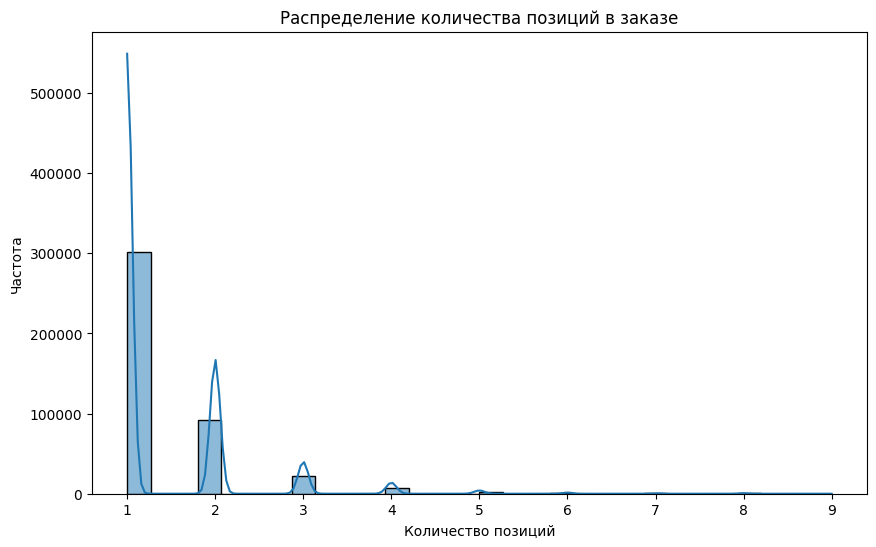

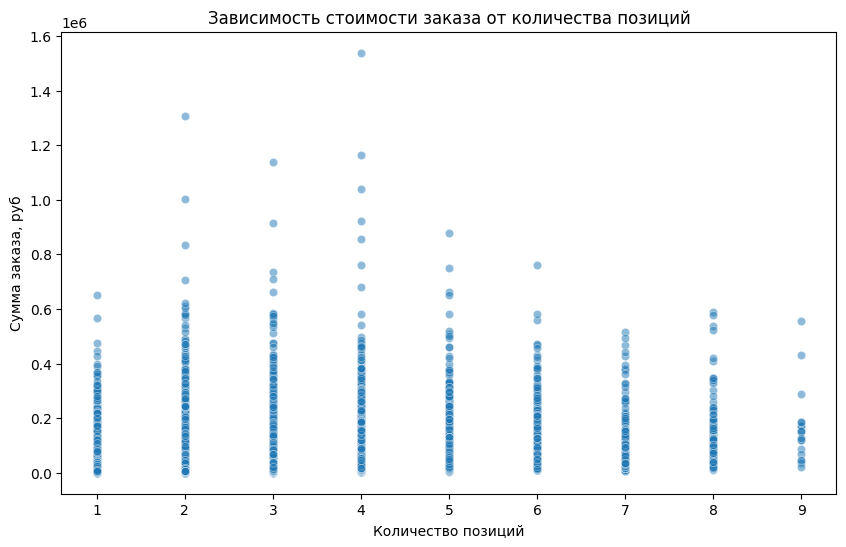

In [64]:
# Распределение order_item_cnt
plt.figure(figsize=(10, 6))
sns.histplot(df_lol['order_item_cnt'], bins=30, kde=True)
plt.title('Распределение количества позиций в заказе')
plt.xlabel('Количество позиций')
plt.ylabel('Частота')
plt.show()

# Корреляция с суммой покупки
plt.figure(figsize=(10, 6))
sns.scatterplot(x=df_lol['order_item_cnt'], y=df_lol['nominal_price_rub_amt'], alpha=0.5)
plt.title('Зависимость стоимости заказа от количества позиций')
plt.xlabel('Количество позиций')
plt.ylabel('Сумма заказа, руб')
plt.show()

In [26]:
married_codes = ['MAR', 'OMR', 'CIV']
df_lol['is_married'] = (
    (df_lol['marital_status_cd'].isin(married_codes)) |  
    (df_lol['children_cnt'] > 0)                         
).map({True: 'Семейные', False: 'Несемейные'})

print("Распределение групп:")
print(df_lol['is_married'].value_counts())

print("\nДети у семейных пользователей:")
print(df_lol[df_lol['is_married'] == 'Семейные']['children_cnt'].describe())

Распределение групп:
is_married
Несемейные    136803
Семейные       87504
Name: count, dtype: int64

Дети у семейных пользователей:
count    87504.000000
mean         0.183820
std          0.574618
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max          8.000000
Name: children_cnt, dtype: float64


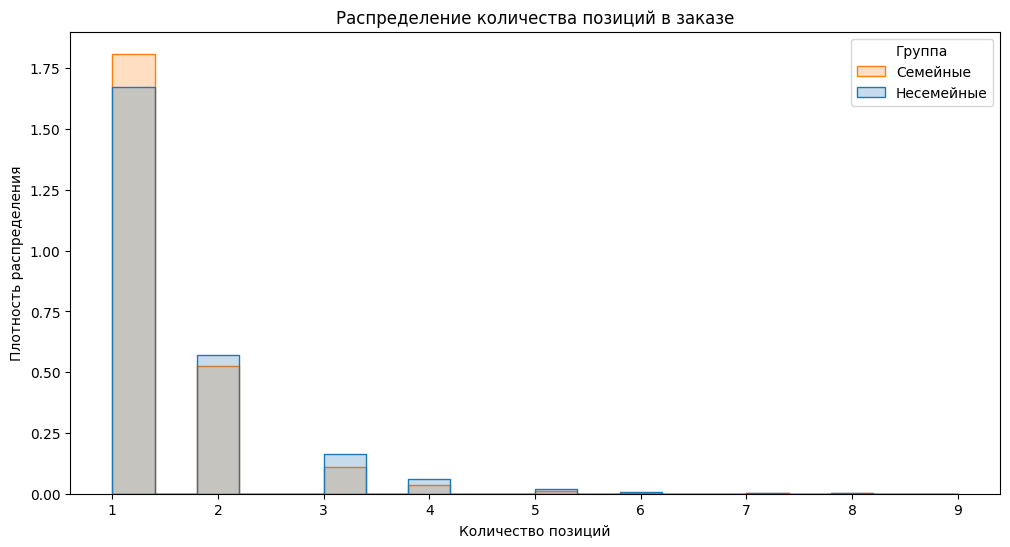

In [28]:
df_clean = df_lol.dropna(subset=['is_married', 'order_item_cnt'])

plt.figure(figsize=(12, 6))

ax = sns.histplot(
    data=df_clean,
    x='order_item_cnt',
    hue='is_married',
    element='step',
    stat='density',
    common_norm=False,
    bins=20,
    palette={'Семейные': '#1f77b4', 'Несемейные': '#ff7f0e'},  
)

plt.legend(
    title='Группа',
    labels=['Семейные', 'Несемейные'],
    loc='upper right'
)

plt.title('Распределение количества позиций в заказе')
plt.xlabel('Количество позиций')
plt.ylabel('Плотность распределения')
plt.show()

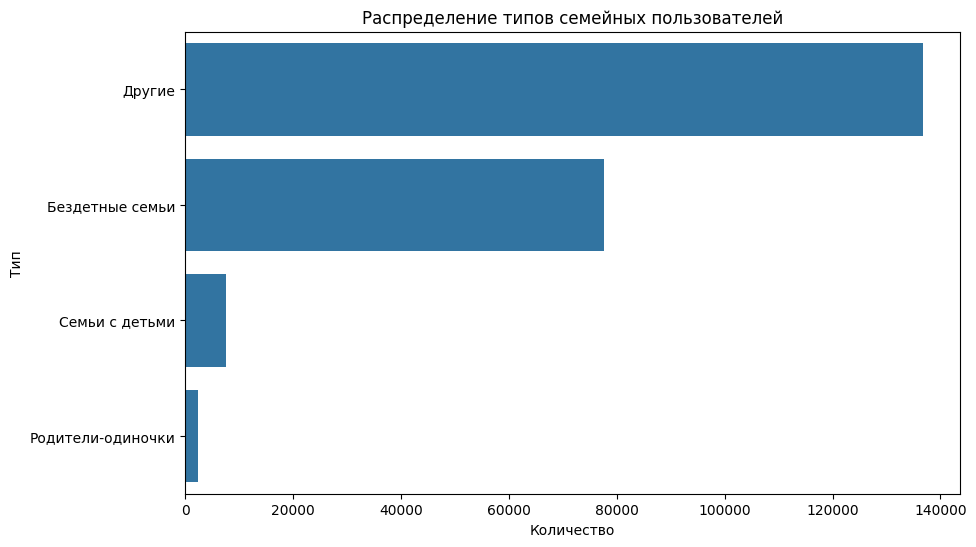

In [29]:
# Разделение на подгруппы
df_clean['family_type'] = np.select(
    [
        (df_clean['marital_status_cd'].isin(married_codes)) & (df_clean['children_cnt'] == 0),
        (df_clean['marital_status_cd'].isin(married_codes)) & (df_clean['children_cnt'] > 0),
        (df_clean['children_cnt'] > 0) & (~df_clean['marital_status_cd'].isin(married_codes))
    ],
    ['Бездетные семьи', 'Семьи с детьми', 'Родители-одиночки'],
    default='Другие'
)

# Визуализация
plt.figure(figsize=(10, 6))
sns.countplot(data=df_clean, y='family_type', order=df_clean['family_type'].value_counts().index)
plt.title('Распределение типов семейных пользователей')
plt.xlabel('Количество')
plt.ylabel('Тип')
plt.show()

In [71]:
stats = df_clean.groupby('is_married')['order_item_cnt'].agg(['mean', 'median', 'std'])
print(stats)

                mean  median       std
is_married                            
Несемейные  1.361624     1.0  0.715439
Семейные    1.485476     1.0  0.860903


In [30]:
from scipy.stats import mannwhitneyu

group1 = df_clean[df_clean['is_married'] == 'Семейные']['order_item_cnt']
group2 = df_clean[df_clean['is_married'] == 'Несемейные']['order_item_cnt']
stat, p_value = mannwhitneyu(group1, group2)
print(f"p-value: {p_value:.4f}")

p-value: 0.0000


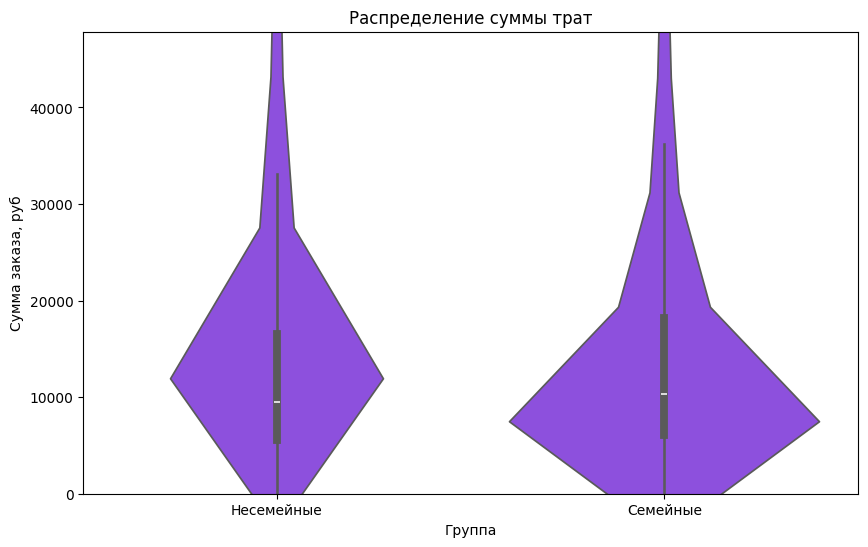

In [107]:
spending_data = df_lol.dropna(subset=['nominal_price_rub_amt', 'is_married'])


spending_stats = spending_data.groupby('is_married')['nominal_price_rub_amt'].agg(['mean', 'median', 'std'])


plt.figure(figsize=(10, 6))
sns.violinplot(
    data=spending_data,
    x='is_married',
    y='nominal_price_rub_amt',
    color='#8A38F5'
)
plt.ylim(0, spending_data['nominal_price_rub_amt'].quantile(0.95)) 
plt.title('Распределение суммы трат')
plt.xlabel('Группа')
plt.ylabel('Сумма заказа, руб')
plt.show()

In [103]:
# Расчет медианы и среднего
stats = df_lol.groupby('is_married')['nominal_price_rub_amt'].agg(['mean', 'median'])
stats

,mean,median
is_married,,
Несемейные,15223.745110,9506.0
Семейные,16936.238945,10329.0


In [ ]:
usage_freq = df_lol.groupby(['client_rk', 'is_married'])['order_rk'].nunique().reset_index()
usage_freq.columns = ['client_rk', 'is_married', 'order_count']

married_orders = usage_freq[usage_freq['is_married'] == 'Семейные']['order_count']
non_married_orders = usage_freq[usage_freq['is_married'] == 'Несемейные']['order_count']

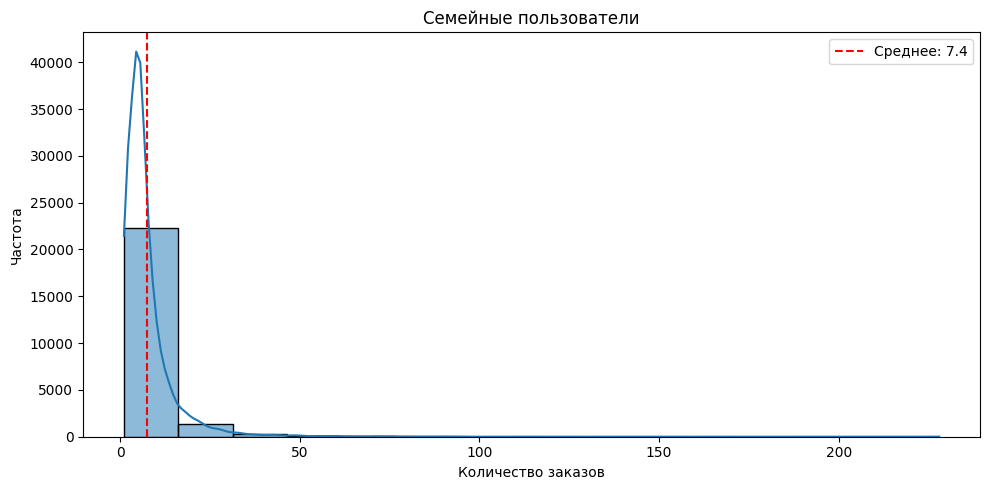

In [95]:
plt.figure(figsize=(10, 5))
sns.histplot(
    married_orders,
    bins=15,
    color='#1f77b4',
    kde=True,
    edgecolor='black'
)
plt.axvline(married_orders.mean(), color='red', linestyle='--', label=f'Среднее: {married_orders.mean():.1f}')
plt.title('Семейные пользователи')
plt.xlabel('Количество заказов')
plt.ylabel('Частота')
plt.legend()

plt.tight_layout()
plt.show()

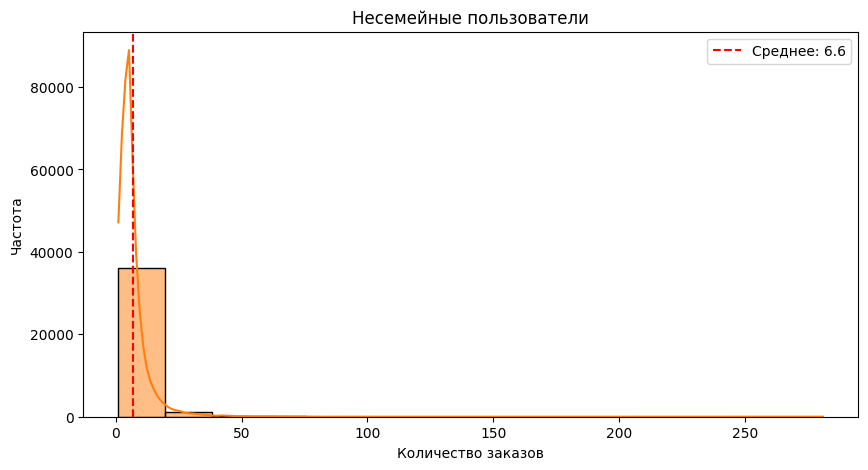

In [106]:
plt.figure(figsize=(10, 5))
sns.histplot(
    non_married_orders,
    bins=15,
    color='#ff7f0e',
    kde=True,
    edgecolor='black'
)
plt.axvline(non_married_orders.mean(), color='red', linestyle='--', label=f'Среднее: {non_married_orders.mean():.1f}')
plt.title('Несемейные пользователи')
plt.xlabel('Количество заказов')
plt.ylabel('Частота')
plt.legend()
plt.show()

In [98]:
print("Семейные пользователи:")
print(f"- Среднее: {married_orders.mean():.1f}")
print(f"- Медиана: {married_orders.median()}")
print(f"- Стандартное отклонение: {married_orders.std():.1f}\n")

print("Несемейные пользователи:")
print(f"- Среднее: {non_married_orders.mean():.1f}")
print(f"- Медиана: {non_married_orders.median()}")
print(f"- Стандартное отклонение: {non_married_orders.std():.1f}")

Семейные пользователи:
- Среднее: 7.4
- Медиана: 5.0
- Стандартное отклонение: 8.7

Несемейные пользователи:
- Среднее: 6.6
- Медиана: 5.0
- Стандартное отклонение: 7.1


# Стат тесты

In [21]:
import statsmodels.api as sm

In [19]:
df_lol = df_cleaned[df_cleaned['order_type_cd'] == "AIR"].copy()
df_lol = df_lol[df_lol['loyalty_accrual_rub_amt'] > 0]

In [22]:
Y = df_lol['loyalty_accrual_rub_amt'] 

X = df_lol['nominal_price_eur_amt']

X = sm.add_constant(X)

model = sm.OLS(Y, X).fit()

model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               OLS Regression Results                              
===================================================================================
Dep. Variable:     loyalty_accrual_rub_amt   R-squared:                       0.841
Model:                                 OLS   Adj. R-squared:                  0.841
Method:                      Least Squares   F-statistic:                 1.185e+06
Date:                     Tue, 13 May 2025   Prob (F-statistic):               0.00
Time:                             21:27:24   Log-Likelihood:            -1.7240e+06
No. Observations:                   224307   AIC:                         3.448e+06
Df Residuals:                       224305   BIC:                         3.448e+06
Df Model:                                1                                         
Covariance Type:                 nonrobust                                         
=========================================================================================
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
const                   -69.6202      1.336    -52.111      0.000     -72.239     -67.002
nominal_price_eur_amt     4.9724      0.005   1088.660      0.000       4.963       4.981
==============================================================================
Omnibus:                   112950.010   Durbin-Watson:                   1.999
Prob(Omnibus):                  0.000   Jarque-Bera (JB):        562681575.976
Skew:                           0.591   Prob(JB):                         0.00
Kurtosis:                     248.364   Cond. No.                         351.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [31]:
from scipy.stats import ttest_ind

group1 = df_lol[df_lol['is_married'] == 'Семейные']['nominal_price_rub_amt']
group2 = df_lol[df_lol['is_married'] == 'Несемейные']['nominal_price_rub_amt']

from scipy.stats import levene
levene_stat, levene_p = levene(group1, group2)
if levene_p > 0.05:
    t_stat, p_value = ttest_ind(group1, group2, equal_var=True)
else:
    t_stat, p_value = ttest_ind(group1, group2, equal_var=False)
print(f"p-value: {p_value:.4f}")

p-value: 0.0000


In [36]:
import numpy as np
from math import sqrt

def cohens_d(group1, group2):
    n1, n2 = len(group1), len(group2)
    s1, s2 = np.var(group1, ddof=1), np.var(group2, ddof=1)
    pooled_std = sqrt(((n1-1)*s1 + (n2-1)*s2) / (n1 + n2 - 2))
    d = (np.mean(group1) - np.mean(group2)) / pooled_std
    return d

d = cohens_d(group1, group2)
print(f"Cohen’s d: {d:.2f}")

Cohen’s d: 0.07


In [32]:
from scipy.stats import mannwhitneyu
u_stat, p_value = mannwhitneyu(group1, group2, alternative='two-sided')
print(f"U-тест: p-value = {p_value:.4f}")

U-тест: p-value = 0.0000


In [34]:
from statsmodels.stats.contingency_tables import mcnemar
import numpy as np

def cliffs_delta(group1, group2):
    n1 = len(group1)
    n2 = len(group2)
    delta = (2 * mannwhitneyu(group1, group2).statistic) / (n1 * n2) - 1
    return delta

delta = cliffs_delta(group1, group2)
print(f"Cliff’s delta: {delta:.2f}")

Cliff’s delta: 0.06


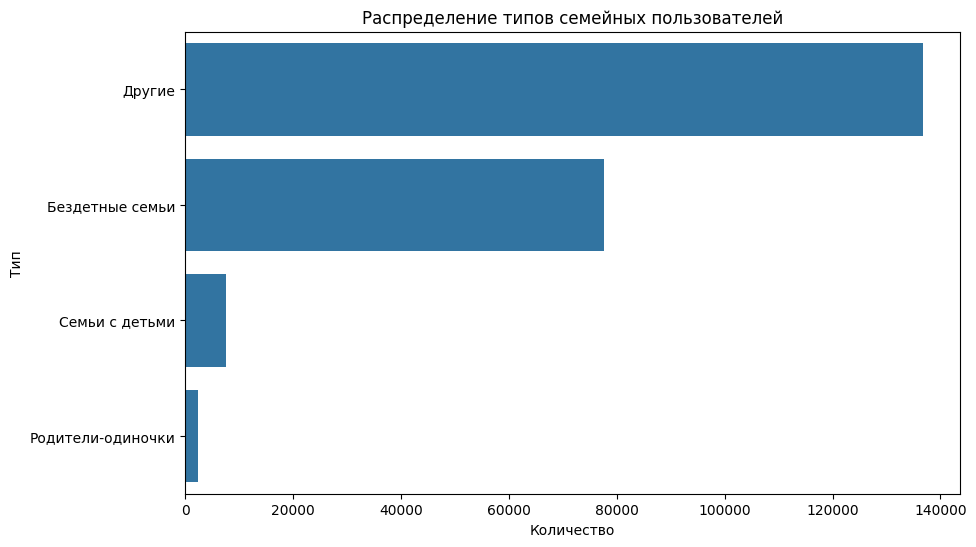

In [ ]:
df_lol['family_type'] = np.select(
    [
        (df_lol['marital_status_cd'].isin(married_codes)) & (df_lol['children_cnt'] == 0),
        (df_lol['marital_status_cd'].isin(married_codes)) & (df_lol['children_cnt'] > 0),
        (df_lol['children_cnt'] > 0) & (~df_lol['marital_status_cd'].isin(married_codes))
    ],
    ['Бездетные семьи', 'Семьи с детьми', 'Родители-одиночки'],
    default='Другие'
)

plt.figure(figsize=(10, 6))
sns.countplot(data=df_clean, y='family_type', order=df_clean['family_type'].value_counts().index)
plt.title('Распределение типов семейных пользователей')
plt.xlabel('Количество')
plt.ylabel('Тип')
plt.show()

In [37]:
from scipy.stats import shapiro

groups = df_lol['family_type'].unique()
for group in groups:
    data = df_lol[df_lol['family_type'] == group]['nominal_price_rub_amt'].dropna()
    stat, p = shapiro(data)
    print(f"Группа: {group}, p-value = {p:.4f}")

Группа: Бездетные семьи, p-value = 0.0000
Группа: Другие, p-value = 0.0000
Группа: Семьи с детьми, p-value = 0.0000
Группа: Родители-одиночки, p-value = 0.0000


/home/lambda/projects/dano/tbank_travel/.venv/lib/python3.13/site-packages/scipy/stats/_axis_nan_policy.py:586: UserWarning: scipy.stats.shapiro: For N > 5000, computed p-value may not be accurate. Current N is 77584.
  res = hypotest_fun_out(*samples, **kwds)
/home/lambda/projects/dano/tbank_travel/.venv/lib/python3.13/site-packages/scipy/stats/_axis_nan_policy.py:586: UserWarning: scipy.stats.shapiro: For N > 5000, computed p-value may not be accurate. Current N is 136803.
  res = hypotest_fun_out(*samples, **kwds)
/home/lambda/projects/dano/tbank_travel/.venv/lib/python3.13/site-packages/scipy/stats/_axis_nan_policy.py:586: UserWarning: scipy.stats.shapiro: For N > 5000, computed p-value may not be accurate. Current N is 7557.
  res = hypotest_fun_out(*samples, **kwds)


In [38]:
from scipy.stats import kruskal

# Фильтрация данных для каждой подгруппы
groups = [
    df_clean[df_clean['family_type'] == 'Бездетные семьи']['nominal_price_rub_amt'],
    df_clean[df_clean['family_type'] == 'Семьи с детьми']['nominal_price_rub_amt'],
    df_clean[df_clean['family_type'] == 'Родители-одиночки']['nominal_price_rub_amt'],
    df_clean[df_clean['family_type'] == 'Другие']['nominal_price_rub_amt']
]

# Удаление пустых групп (если есть)
groups = [group for group in groups if len(group) > 0]

# Тест Краскела-Уоллиса
h_stat, p_value = kruskal(*groups)
print(f"Тест Краскела-Уоллиса: p-value = {p_value:.4f}")

Тест Краскела-Уоллиса: p-value = 0.0000


In [39]:
def cliffs_delta(group1, group2):
    n1, n2 = len(group1), len(group2)
    u_stat, _ = mannwhitneyu(group1, group2)
    delta = (2 * u_stat) / (n1 * n2) - 1
    return delta

# Пример для пары "Семьи с детьми vs Бездетные семьи"
group1 = df_clean[df_clean['family_type'] == 'Семьи с детьми']['nominal_price_rub_amt']
group2 = df_clean[df_clean['family_type'] == 'Бездетные семьи']['nominal_price_rub_amt']
delta = cliffs_delta(group1, group2)
print(f"Cliff’s delta: {delta:.3f}")

Cliff’s delta: 0.017
